# Module loading

In [ ]:
import numpy as np
import pandas as pd
import random
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from IPython.core.pylabtools import figsize
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet
import nltk
import string
from string import punctuation
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.utils.extmath import randomized_svd
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
from sklearn.metrics import auc, roc_curve, plot_roc_curve, plot_confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn import datasets, metrics, model_selection, svm
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from nltk.stem import PorterStemmer
from sklearn.pipeline import Pipeline
from tempfile import mkdtemp
from joblib import Memory
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
drive.mount('/content/drive')

In [ ]:
#for local testing
# df = pd.read_csv("Downloads/Project1-Classification.csv")
df = pd.read_csv("drive/My Drive/ECE 219/Project1-Classification.csv")
df.head()

,full_text,summary,keywords,publish_date,authors,url,leaf_label,root_label
0,"'Pure Hockey, the largest hockey retailer in t...","'Pure Hockey, the largest hockey retailer in t...","['acquire', 'agrees', 'nevada', 'retail', 'hoc...",2022-10-21 17:11:22+00:00,['Ein News'],https://www.einnews.com/pr_news/597148062/pure...,hockey,sports
1,'HKO Hockey Canada Sponsorship 20221006\n\nHoc...,'The tally of Hockey Canada’s sponsorship loss...,"['sexual', 'exclusive', 'settlement', 'million...",NaN,['Barbara Shecter'],https://ca.finance.yahoo.com/news/exclusive-ho...,hockey,sports
2,'Canadian Prime Minister Justin Trudeau said W...,'Canadian Prime Minister Justin Trudeau said W...,"['québec', 'surprise', 'trust', 'sexual', 'org...",2022-10-05 00:00:00,['The Athletic Staff'],https://theathletic.com/3659888/2022/10/05/hoc...,hockey,sports
3,'Hockey Canada paid a crisis communications fi...,'Nicholson says that Hockey Canada did not go ...,"['sexual', 'organization', 'million', 'ceo', '...",2022-11-15 00:00:00,['Dan Robson'],https://theathletic.com/3900630/2022/11/15/hoc...,hockey,sports
4,'The Denver Broncos are looking for a new head...,'The Denver Broncos are looking for a new head...,"['beats', 'force', 'season', 'teams', 'anchora...",NaN,"['Parker Seibold', 'The Gazette', 'Gazette File']",https://gazette.com/multimedia/photo-air-force...,hockey,sports


# Question 1

In [ ]:
df.shape

(3150, 8)

### How many rows (samples) and columns (features) are present in the dataset?
- There are 3150 rows and 8 features presented in the dataset.

In [ ]:
df['totalwords'] = df['full_text'].str.split().str.len()
df['totalwords'].head()

0     430
1     936
2     788
3    1256
4      32
Name: totalwords, dtype: int64

### The total number of alpha-numeric characters per data point (row) in the feature full text

Text(0.5, 1.0, 'The total number of alpha-numeric characters per data point (row) in the feature full text')

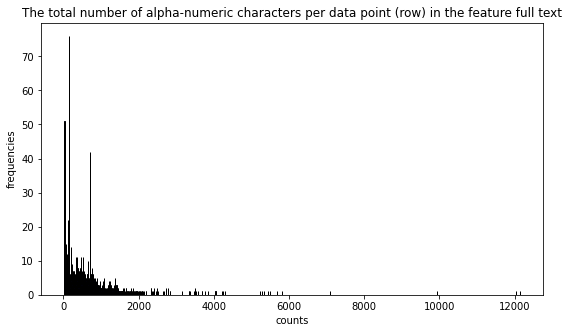

In [ ]:
# (a) The total number of alpha-numeric characters per data point (row) in the feature full text
figsize(9,5)
nparr=df['totalwords'].to_numpy()
values, counts = np.unique(nparr, return_counts=True)
plt.bar(values,counts, color='blue', edgecolor = 'black')
plt.ylabel('frequencies')
plt.xlabel('counts')
plt.title('The total number of alpha-numeric characters per data point (row) in the feature full text')

### The column leaf label – class on the x-axis

Text(0.5, 1.0, 'With column leaf label on the x-axis')

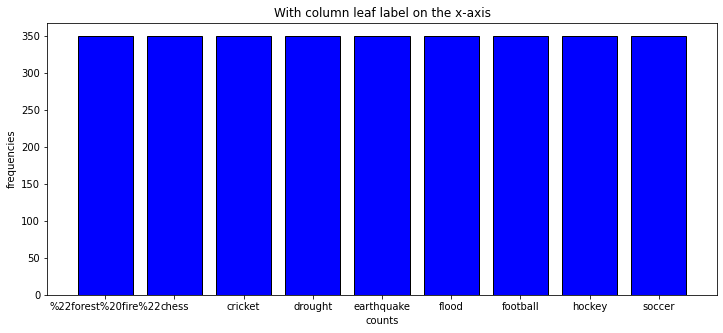

In [ ]:
#(b) The column leaf label – class on the x-axis
nparr=df['leaf_label'].to_numpy()
values, counts = np.unique(nparr, return_counts=True)
figsize(12,5)

plt.bar(values,counts, color='blue', edgecolor = 'black')
plt.ylabel('frequencies')
plt.xlabel('counts')
plt.title('With column leaf label on the x-axis')

### The column root label – class on the x-axis

Text(0.5, 1.0, 'With column root label on the x-axis')

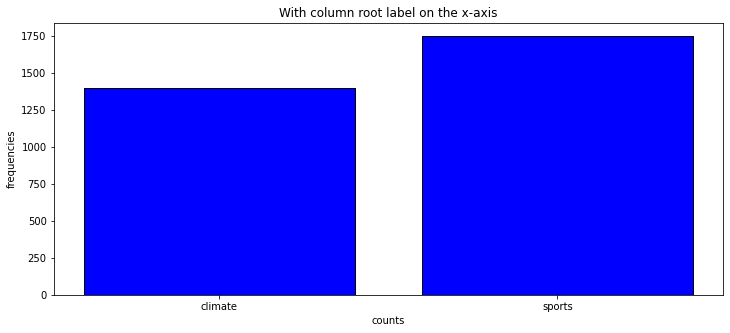

In [ ]:
#(c) The column root label – class on the x-axis.
#• Interpret Plots: Provide qualitative interpretations of the histograms.
nparr=df['root_label'].to_numpy()
values, counts = np.unique(nparr, return_counts=True)
figsize(12,5)

plt.bar(values,counts, color='blue', edgecolor = 'black')
plt.ylabel('frequencies')
plt.xlabel('counts')
plt.title('With column root label on the x-axis')

### Qualitative interpretations:
- From the above graphs, we conclude that while we have an equal number of samples(rows) for each leaf sample.
- On the other hand, there's a slight difference between the number of samples for the columns of root label, which stems from the root label "sports" having one extra leaf label.
- Another observation is that the variance of word counts between different samples is quite high, with some outliers at over 7000 words.

# Question 2


In [ ]:
train, test = train_test_split(df[["full_text","root_label"]], test_size=0.2)
#checking text after cleaning
train['full_text'].head()

2365    'FORT LAUDERDALE, Fla. — Just weeks before the...
152     'A teenage hockey player died on Christmas Day...
1395    'East Rutherford, NJ – The New York Giants and...
875     'Starting this season, the NFL will honor the ...
228     'On Monday, 20 former patients from UMC Childr...
Name: full_text, dtype: object

In [ ]:
np.random.seed(42)
random.seed(42)
#define cleaning function
def clean(text):
 text = re.sub (r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
 texter = re.sub(r"<br />", " ", text)
 texter = re.sub(r"&quot;", "\"",texter)
 texter = re.sub('&#39;', "\"", texter)
 texter = re.sub('\n', " ", texter)
 texter = re.sub(' u '," you ", texter)
 texter = re.sub('`',"", texter)
 texter = re.sub(' +', ' ', texter)
 texter = re.sub(r"(!)\1+", r"!", texter)
 texter = re.sub(r"(\?)\1+", r"?", texter)
 texter = re.sub('&amp;', 'and', texter)
 texter = re.sub('\r', ' ',texter)
 clean = re.compile('<.*?>')
 texter = texter.encode('ascii', 'ignore').decode('ascii')
 texter = re.sub(clean, '', texter)
 if texter == "":
  texter = ""
 return texter

#clean raw text
for i in df['full_text']:
  clean(i)
df['full_text'] = df['full_text'].str.replace('\d+', '') # for digits
df['full_text'] = df['full_text'].str.replace('[^\w\s]', '') # for punctuation 

print("\n")
print("Training samples size:", train.shape)
print("Testing samples size:", test.shape)

<ipython-input-9-20dd30fe6ba7>:27: FutureWarning: The default value of regex will change from True to False in a future version.
  df['full_text'] = df['full_text'].str.replace('\d+', '') # for digits
<ipython-input-9-20dd30fe6ba7>:28: FutureWarning: The default value of regex will change from True to False in a future version.
  df['full_text'] = df['full_text'].str.replace('[^\w\s]', '') # for punctuation




Training samples size: (2520, 2)
Testing samples size: (630, 2)


### Report the number of training and testing samples.

A:

The training samples contain 2520 rows and 2 features.

The testing samples contain 630 rows and 2 features.

# Question 3

In [ ]:
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
def lemmatize_sent(text): 
    # Text input is string.
    # Returns sequence of lowercased strings(words).
    lemma_list = []
    lemma_list = [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(nltk.word_tokenize(text))]
    # Turn array of strings into sequence
    return ' '.join(lemma_list)


In [ ]:
wnl = WordNetLemmatizer()
vec = CountVectorizer(stop_words='english', min_df=3)
tfidf = TfidfTransformer()

X_train_lemma = []
X_test_lemma = []
for i in range(len(train)):
  # print(lemmatize_sent(train.iloc[i]['full_text']))
  X_train_lemma.append(lemmatize_sent(train.iloc[i]['full_text']))
for i in range(len(test)):
  X_test_lemma.append(lemmatize_sent(test.iloc[i]['full_text']))

X_train_vec = vec.fit_transform(X_train_lemma)
X_test_vec = vec.transform(X_test_lemma)
X_train_tfidf = tfidf.fit_transform(X_train_vec)
X_test_tfidf = tfidf.transform(X_test_vec)
print("X_train shape:", X_train_tfidf.shape)
print("X_test shape:", X_test_tfidf.shape)

X_train shape: (2520, 14617)
X_test shape: (630, 14617)


### What are the pros and cons of lemmatization versus stemming? How do these processes affect the dictionary size?

A: 
The main advantage of lemmatization is that it takes into consideration the context of the word to determine which is the intended meaning the user is looking for. This process allows to decrease noise and speed up the user’s task. However,because lemmatization involves deriving the meaning of a word from something like a dictionary, it's very time consuming.

Stemming usually refers to a process of chopping off the last few characters. Stemming operates on a single word without knowledge of the context. Stemming is not a well-defined process, it often suffers from incorrect meaning and spelling errors.

### min df means minimum document frequency. How does varying min df change the TF-IDF matrix?

A: 

When we increase the min df, it will decrease the column counts of the matrix, because the goal of MIN_DF is to ignore words that have very few occurrences to be considered meaningful. 

### Should I remove stopwords before or after lemmatizing? Should I remove punctuations before or after lemmatizing? Should I remove numbers before or after lemmatizing?

A: 

We should remove stopwords after lemmatizing but remove punctuations before lemmatizing. Because in certain cases, stop words do indeed contribute meaning, and if an application is sensitive to such meanings, then stop words should not be eliminated.

### Report the shape of the TF-IDF-processed train and test matrices. The number of rows should match the results of Question 2. The number of columns should roughly be in the order of $k × 10^3 $.

A: 

The train matrices contains 2520 rows and 14224 columns and the test set contains 630 rows and 14224 columns.

# Question 4

explained_variance_ratio when k = 1 : 0.006224825213568656
explained_variance_ratio when k = 10 : 0.15071903785672722
explained_variance_ratio when k = 50 : 0.30882595512242966
explained_variance_ratio when k = 100 : 0.3969366348332619
explained_variance_ratio when k = 200 : 0.5081589654140468
explained_variance_ratio when k = 500 : 0.7034444519048018
explained_variance_ratio when k = 1000 : 0.8770156830085055
explained_variance_ratio when k = 2000 : 0.9999363548878676


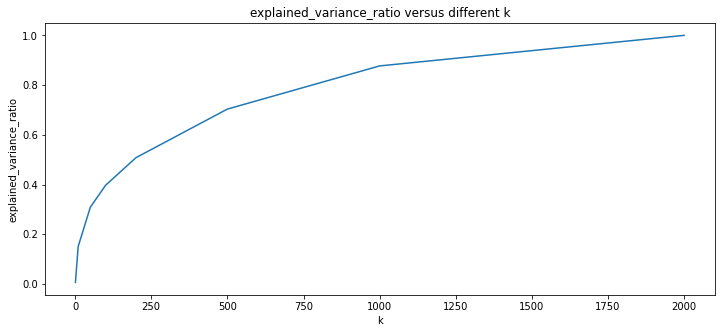



LSI:
training data shape =  (2520, 50)
test data shape =  (630, 50)
NMF:
training data shape =  (2520, 50)
test data shape =  (630, 50)


the reconstruction residual MSE error:
When using LSI:
training error: 1684.3349577485965
test error: 392.697960036842
When using NMF:
training error: 1711.2112622315972
test error: 441.68040727548663


In [ ]:
ks = [1, 10, 50, 100, 200, 500, 1000, 2000]
ratios = []
for i in range(len(ks)):
  svd_tmp = TruncatedSVD(n_components=ks[i], random_state=42)
  # print(svd_tmp.explained_variance_ratio_)
  svd_tmp.fit(X_train_tfidf)
  print("explained_variance_ratio when k =", ks[i], ":", svd_tmp.explained_variance_ratio_.sum())
  ratios.append(svd_tmp.explained_variance_ratio_.sum())


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(ks, ratios)

ax.set_ylabel('explained_variance_ratio')
ax.set_xlabel('k')
plt.title('explained_variance_ratio versus different k')
plt.show()

svd = TruncatedSVD(n_components=50, random_state=42)
nmf = NMF(n_components=50, init='random', random_state=42)

print("\n")
# LSI
X_train_LSI = svd.fit_transform(X_train_tfidf)
X_test_LSI = svd.transform(X_test_tfidf)
# NMF
X_train_NMF = nmf.fit_transform(X_train_tfidf)
X_test_NMF = nmf.transform(X_test_tfidf)
# W = X_test_xxx
# H = nmf.components_

# data shape
print("LSI:")
print('training data shape = ', X_train_LSI.shape)
print('test data shape = ', X_test_LSI.shape)
print("NMF:")
print('training data shape = ', X_train_NMF.shape)
print('test data shape = ', X_test_NMF.shape)


# calculate the reconstruction residual MSE error
train_U, train_S, train_V = randomized_svd(X_train_tfidf, n_components=50, random_state=42)
test_U, test_S, test_V = randomized_svd(X_test_tfidf, n_components=50, random_state=42)
print("\n")
print("the reconstruction residual MSE error:")
print("When using LSI:")
print('training error:',np.sum(np.array(X_train_tfidf - (train_U.dot(np.diag(train_S)).dot(train_V)))**2))
print('test error:',np.sum(np.array(X_test_tfidf - (test_U.dot(np.diag(test_S)).dot(test_V)))**2))

print("When using NMF:")
print('training error:',np.sum(np.array(X_train_tfidf - X_train_NMF.dot(nmf.components_))**2))
print('test error:',np.sum(np.array(X_test_tfidf - X_test_NMF.dot(nmf.components_))**2))


### What does the explained variance ratio plot look like? What does the plot’s concavity suggest?

A:

The plot looks like a concave down durve. As k increases, the explained variance ratio getting larger. In which makes sense since the ratio reflects how much variation of the target value(Y) is explained by the data features(X).

### With k = 50 found in the previous sections, calculate the reconstruction residual MSE error when using LSI and NMF – they both should use the same k = 50. Which one is larger, the $∥X − WH∥_2^F$ in NMF or the $∥X − U_kΣ_kV^T_k∥^F_2$ in LSI and why?

A:

As you can see, both the training error and test error in NMF are larger than those in LSI. 

It makes sense because LSI is a more insightful method by giving us more information with the SVD factorization. Therefore, its mse error will be lower than NMF as we expect.

# Question 5

In [ ]:
map_root = {"sports":1, "climate":0}
y_train = train['root_label'].map(map_root)
y_test = test['root_label'].map(map_root)

In [ ]:
def print_roc_curve(X_test_LSI, y_test, model, plt_title, colar):
  fig, ax = plt.subplots()
  plot_roc_curve(model, X_test_LSI, y_test, ax=ax, color=colar)
  ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.5)
  plt.title(plt_title)
  plt.show()

def print_cf_matrix(X_test_LSI, y_test, model, plt_title, display_labels):
  plot_confusion_matrix(model, X_test_LSI, y_test, display_labels=display_labels)
  plt.tight_layout()
  plt.title(plt_title)
  # plt.savefig(image_name)
  plt.show()

def print_result(model_title, y_test, y_pred):
  print(model_title, ":")
  print("Accuracy:", accuracy_score(y_test, y_pred))
  print("Recall:", recall_score(y_test, y_pred))
  print("Precision:", precision_score(y_test, y_pred))
  print("F1-Score:", f1_score(y_test, y_pred), "\n")

def print_multi_result(model_title, y_test, y_pred):
  print(model_title, ":")
  print("Accuracy:", accuracy_score(y_test, y_pred))
  print("Recall:", recall_score(y_test, y_pred, average='weighted'))
  print("Precision:", precision_score(y_test, y_pred, average='weighted'))
  print("F1-Score:", f1_score(y_test, y_pred, average='weighted'), "\n")

root_labels = ['climate', 'sports']

### Train one SVM with γ = 1000 (hard margin), another with γ = 0.0001 (soft margin)

In [ ]:
# build the svm with given gamma
hard_svm = svm.SVC(kernel='linear', C=1000, random_state=42)
soft_svm = svm.SVC(kernel='linear', C=0.0001, random_state=42)
harder_svm = svm.SVC(kernel='linear', C=100000, random_state=42)

# fit the model
hard_svm.fit(X_train_LSI, y_train)
soft_svm.fit(X_train_LSI, y_train)
harder_svm.fit(X_train_LSI, y_train)

# predict the test data
hard_y_pred = hard_svm.predict(X_test_LSI)
soft_y_pred = soft_svm.predict(X_test_LSI)
harder_y_pred = harder_svm.predict(X_test_LSI)

###  Plot the ROC curve, report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of both SVM classifiers on the testing set. Which one performs better? What about for γ = 100000?

A:

As you can find in the following sections, the hard margin one performs better in this dataset. And the one with γ = 100000 performs even better than the hard margin one a little bit.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


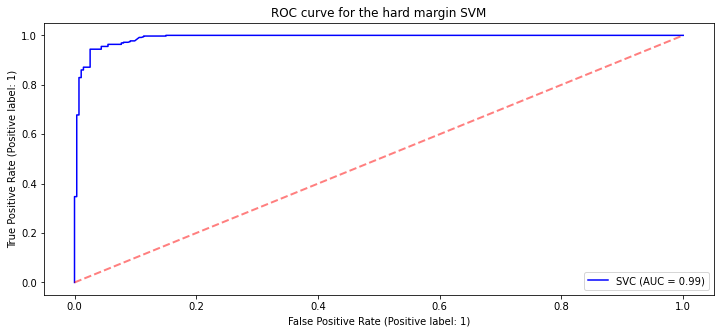

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


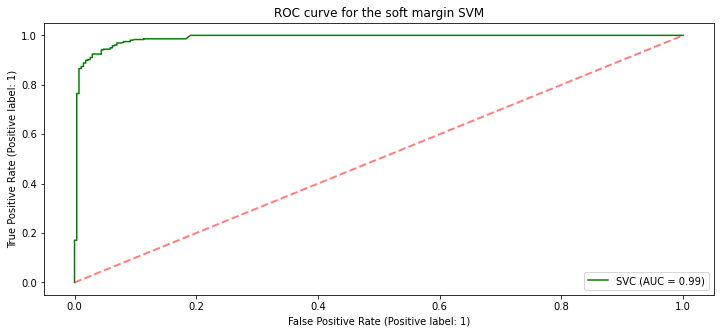

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


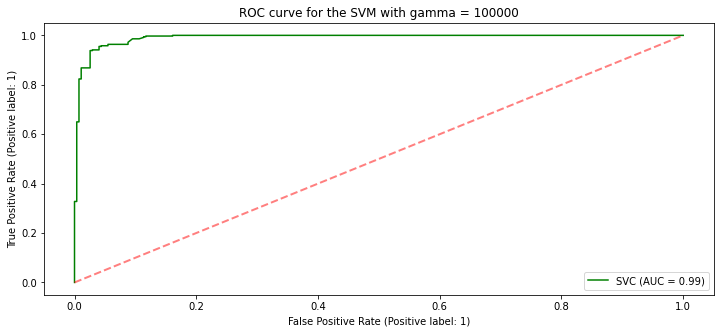

In [ ]:
print_roc_curve(X_test_LSI, y_test, hard_svm, 'ROC curve for the hard margin SVM', 'b')
print_roc_curve(X_test_LSI, y_test, soft_svm, 'ROC curve for the soft margin SVM', 'g')
print_roc_curve(X_test_LSI, y_test, harder_svm, 'ROC curve for the SVM with gamma = 100000', 'g')

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


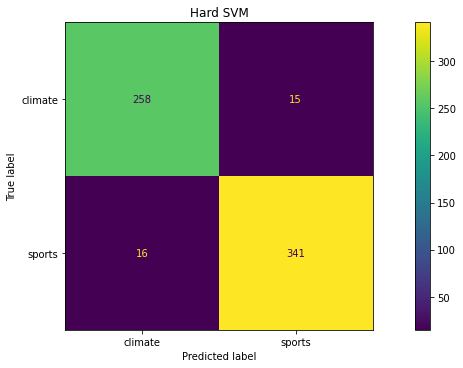

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


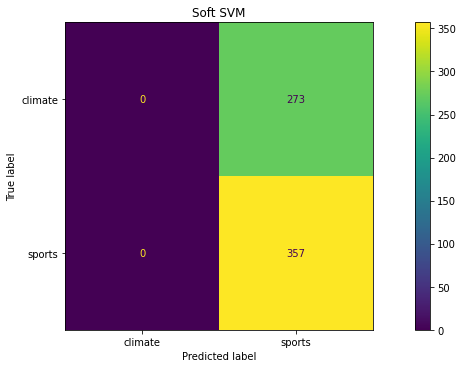

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


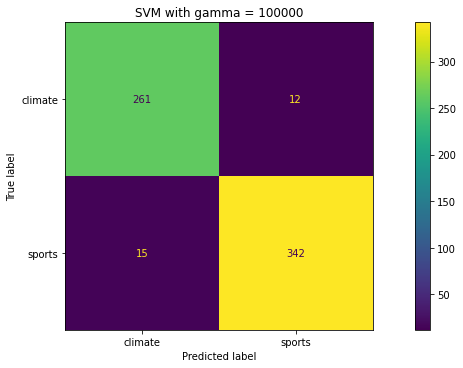

In [ ]:
print_cf_matrix(X_test_LSI, y_test, hard_svm, 'Hard SVM', display_labels=root_labels)
print_cf_matrix(X_test_LSI, y_test, soft_svm, 'Soft SVM', display_labels=root_labels)
print_cf_matrix(X_test_LSI, y_test, harder_svm, 'SVM with gamma = 100000', display_labels=root_labels)

In [ ]:
print_result("Hard SVM", y_test, hard_y_pred)
print_result("Soft SVM", y_test, soft_y_pred)
print_result("SVM with gamma = 100000", y_test, harder_y_pred)

Hard SVM :
Accuracy: 0.9507936507936507
Recall: 0.9551820728291317
Precision: 0.9578651685393258
F1-Score: 0.9565217391304349 

Soft SVM :
Accuracy: 0.5666666666666667
Recall: 1.0
Precision: 0.5666666666666667
F1-Score: 0.7234042553191489 

SVM with gamma = 100000 :
Accuracy: 0.9571428571428572
Recall: 0.957983193277311
Precision: 0.9661016949152542
F1-Score: 0.9620253164556962 



### What happens for the soft margin SVM? Why is the case? Analyze in terms of the confusion matrix

A:

From the confusion matrix of soft margin SVM, you can find that it predicts all the test data into the "sports" category. In which might because of its margin is too small to allow the model classify different data and makes the misclassification of data not being punished.

#### Does the ROC curve reflect the performance of the soft-margin SVM? Why?

A:

No. It doesn't reflect the performance.

The ROC curve is a plot of True Positive Rate (TPR) on the y-axis vs. False Positive Rate (FPR) on the x-axis.

$TPR = \frac{True Positive}{True Positive + False Negative}$

$FPR = \frac{False Positive}{False Positive + True Negative}$

Since the model predicts all the test data into the "sports" label, you can find out that the TPR and FPR are all **equal to 1** in this situation.
Therefore, the ROC curve is not useful to evaluate the performance of the soft-margin SVM.

### Use cross-validation to choose γ (use average validation 3 accuracy to compare): Using a 5-fold cross-validation, find the best value of the parameter γ in the range {10k | − 3 ≤ k ≤ 6, k ∈ Z}. Again, plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1 score of this best SVM.

After using the cross-validation, we can find out the best γ to use here is 100.

In [ ]:
svc = svm.SVC(random_state=42)
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000], 'kernel': ['linear']}

clf = GridSearchCV(svc, parameters, cv=5, scoring='accuracy')
clf.fit(X_train_LSI, y_train)
best_y_pred = clf.best_estimator_.predict(X_test_LSI)

Best Value of γ: 10000
γ: 0.001	 average validation accuracy: 0.5527777777777778
γ: 0.01	 average validation accuracy: 0.5531746031746032
γ: 0.1	 average validation accuracy: 0.9369047619047619
γ: 1	 average validation accuracy: 0.9472222222222223
γ: 10	 average validation accuracy: 0.9523809523809523
γ: 100	 average validation accuracy: 0.9543650793650794
γ: 1000	 average validation accuracy: 0.9539682539682539
γ: 10000	 average validation accuracy: 0.9547619047619047
γ: 100000	 average validation accuracy: 0.9539682539682539
γ: 1000000	 average validation accuracy: 0.9543650793650794


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


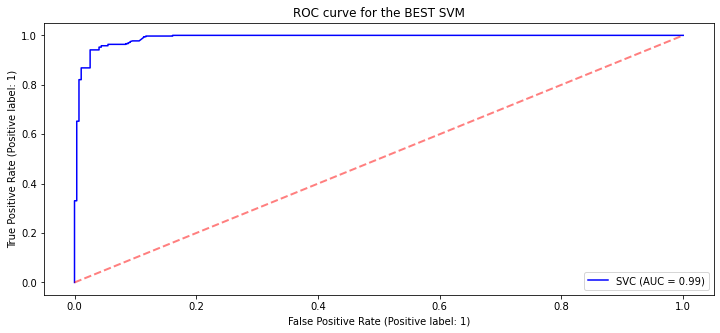

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


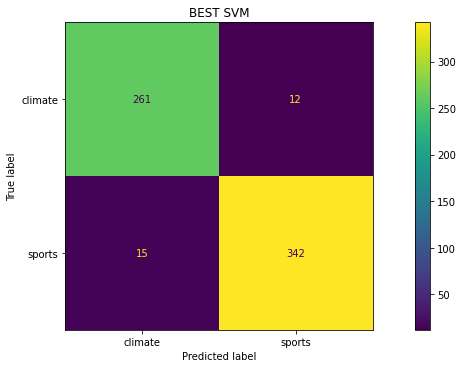

BEST SVM :
Accuracy: 0.9571428571428572
Recall: 0.957983193277311
Precision: 0.9661016949152542
F1-Score: 0.9620253164556962 



In [ ]:
print('Best Value of γ:',clf.best_params_['C']) 
for l, n in zip(parameters['C'], clf.cv_results_['mean_test_score']):
    print(f'γ: {l}\t',f'average validation accuracy: {n}')
print_roc_curve(X_test_LSI, y_test, clf.best_estimator_, 'ROC curve for the BEST SVM', 'b')
print_cf_matrix(X_test_LSI, y_test, clf.best_estimator_, 'BEST SVM', display_labels=root_labels)
print_result("BEST SVM", y_test, best_y_pred)

# Question 6

### Train a logistic classifier without regularization (you may need to come up with some way to approximate this if you use sklearn.linear model.LogisticRegression); plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1 score of this classifier on the testing set.

In [ ]:
log_wor = LogisticRegression(penalty='none', random_state=9527, max_iter=100000)
log_wor.fit(X_train_LSI, y_train)
log_wor_y_pred = log_wor.predict(X_test_LSI)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


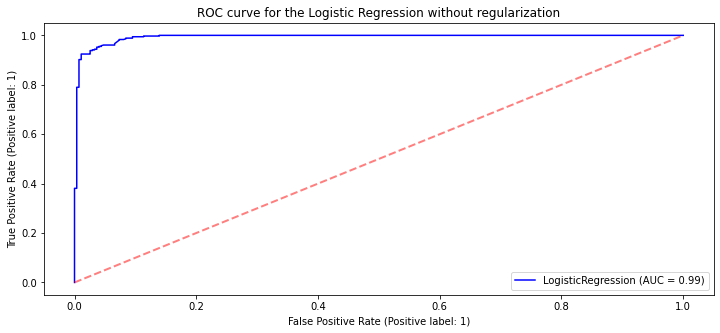

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


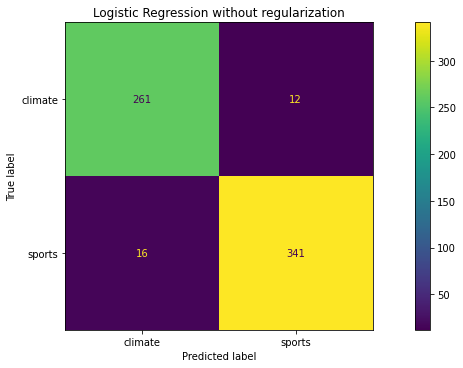

Logistic Regression without regularization :
Accuracy: 0.9555555555555556
Recall: 0.9551820728291317
Precision: 0.9660056657223796
F1-Score: 0.9605633802816901 



In [ ]:
print_roc_curve(X_test_LSI, y_test, log_wor, 'ROC curve for the Logistic Regression without regularization', 'b')
print_cf_matrix(X_test_LSI, y_test, log_wor, 'Logistic Regression without regularization', display_labels=root_labels)
print_result("Logistic Regression without regularization", y_test, log_wor_y_pred)

### Using 5-fold cross-validation on the dimension-reduced-by-SVD training data, find the optimal regularization strength in the range {10k | −5 ≤ k ≤ 5, k ∈ Z} for logistic regression with L1 regularization and logistic regression with L2 regularization, respectively.

In [ ]:
# L1 regularization
log_l1 = LogisticRegression(penalty='l1', random_state=9527, solver='liblinear', max_iter=100000)
parameters = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
clf_l1 = GridSearchCV(log_l1, parameters, cv=5, scoring='accuracy')
clf_l1.fit(X_train_LSI, y_train)
l1_best_y_pred = clf_l1.best_estimator_.predict(X_test_LSI)
# L2 regularization
log_l2 = LogisticRegression(penalty='l2', random_state=9527, solver='liblinear', max_iter=100000)
parameters = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
clf_l2 = GridSearchCV(log_l2, parameters, cv=5, scoring='accuracy')
clf_l2.fit(X_train_LSI, y_train)
l2_best_y_pred = clf_l2.best_estimator_.predict(X_test_LSI)

### Compare the performance (accuracy, precision, recall and F-1 score) of 3 logistic classifiers: w/o regularization, w/ L1 regularization and w/ L2 regularization (with the best parameters you found from the part above), using test data.

A:

When using the best parameter we found, we can find that we get the exact same performance of 3 different logistic classifiers.

In [ ]:
print('Best Value of regularization strength in L1 regularization:',clf_l1.best_params_['C']) 
for l, n in zip(parameters['C'], clf_l1.cv_results_['mean_test_score']):
    print(f'reg. strength(C):{l}\t',f'average validation accuracy: {n}')

print('\nBest Value of regularization strength in L2 regularization:',clf_l2.best_params_['C']) 
for l, n in zip(parameters['C'], clf_l2.cv_results_['mean_test_score']):
    print(f'reg. strength(C):{l}\t',f'average validation accuracy: {n}')

Best Value of regularization strength in L1 regularization: 100
reg. strength(C):1e-05	 average validation accuracy: 0.44722222222222224
reg. strength(C):0.0001	 average validation accuracy: 0.44722222222222224
reg. strength(C):0.001	 average validation accuracy: 0.44722222222222224
reg. strength(C):0.01	 average validation accuracy: 0.5527777777777778
reg. strength(C):0.1	 average validation accuracy: 0.923015873015873
reg. strength(C):1	 average validation accuracy: 0.9428571428571428
reg. strength(C):10	 average validation accuracy: 0.9547619047619047
reg. strength(C):100	 average validation accuracy: 0.9563492063492063
reg. strength(C):1000	 average validation accuracy: 0.9563492063492063
reg. strength(C):10000	 average validation accuracy: 0.9563492063492063
reg. strength(C):100000	 average validation accuracy: 0.9563492063492063

Best Value of regularization strength in L2 regularization: 100000
reg. strength(C):1e-05	 average validation accuracy: 0.5527777777777778
reg. strength

In [ ]:
print_result("Logistic Regression without regularization", y_test, log_wor_y_pred)
print_result("Logistic Regression with L1 regularization", y_test, l1_best_y_pred)
print_result("Logistic Regression with L2 regularization", y_test, l2_best_y_pred)

Logistic Regression without regularization :
Accuracy: 0.9555555555555556
Recall: 0.9551820728291317
Precision: 0.9660056657223796
F1-Score: 0.9605633802816901 

Logistic Regression with L1 regularization :
Accuracy: 0.9555555555555556
Recall: 0.9551820728291317
Precision: 0.9660056657223796
F1-Score: 0.9605633802816901 

Logistic Regression with L2 regularization :
Accuracy: 0.9555555555555556
Recall: 0.9551820728291317
Precision: 0.9660056657223796
F1-Score: 0.9605633802816901 



### How does the regularization parameter affect the test error? How are the learnt coefficients affected? Why might one be interested in each type of regularization?

A:

From our experiment, we didn't see much differences in the accuracy or error when using the best parameter in different regularization. However, the best parameter of l2 regularization is much higher than l1 regularization. 

We can think of that all these models can reach a limit when we find the best parameter to use. Therefore, the different bias (regularizations) we add to the model doesn't affect the performance.

### Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary. What is the difference between their ways to find this boundary? Why do their performances differ? Is this difference statistically significant?

A:

Logistic regression maximizes the conditional probability likelihood to find the decision boundary. SVM use geometric and deterministic method to separate the hyperplane and find the vectors of the margin. 

Therefore, SVM can yield a deterministic hyperplane to improve accuracy and reduce error rate. In which makes it more generalized and efficient. On the other hand, logistic regression is more likely to overfitting since its decision is basically relied on the dataset. In which makes it get higher accuracy more easily but lose the generality instead.

Lastly, the difference in this dataset is not statistically significant since the difference is approximately 0.008. We believe there is no much difference when we can find the best parameters in each model.


# Question 7

### Evaluate and profile a Na¨ıve Bayes classifier: Train a GaussianNB classifier; plot the ROC curve and report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of this classifier on the testing set.

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train_LSI, y_train)
gnb_y_pred = gnb.predict(X_test_LSI)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


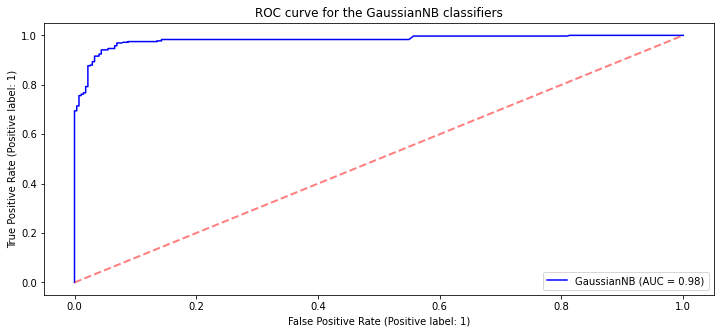

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


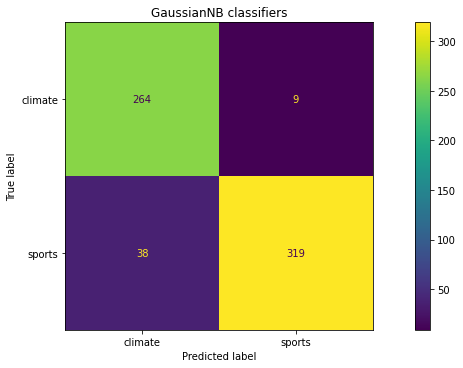

GaussianNB classifiers :
Accuracy: 0.9253968253968254
Recall: 0.8935574229691877
Precision: 0.9725609756097561
F1-Score: 0.9313868613138686 



In [ ]:
print_roc_curve(X_test_LSI, y_test, gnb, 'ROC curve for the GaussianNB classifiers', 'b')
print_cf_matrix(X_test_LSI, y_test, gnb, 'GaussianNB classifiers', display_labels=root_labels)
print_result("GaussianNB classifiers", y_test, gnb_y_pred)

# Question 8

In [ ]:
X_train = train['full_text']
print(X_train)

83      'Following a pandemic-induced two-year delay, ...
2645    'Lead Stories:\n\n1. The Aftershock Festival s...
2293    'Weather Street Sweeping Suspended In Hoboken ...
1725    'Robert Duvall has a supporting role in the pe...
2066    'Aircraft Returning to Field Causes 10-Acre Br...
                              ...                        
774     'This weekend brings us a battle between ranke...
181     'The Bulldog Insider Podcast returns this week...
1166    'About Photo #4837929: Catherine, Princess of ...
1614    'A listener wrote into Bobby Bones mailbag say...
2202    'The housing industry, from servicers to real ...
Name: full_text, Length: 2520, dtype: object


In [ ]:
def stemming_sent(text): 
    # Text input is string.
    # Returns sequence of lowercased strings(words).
    porter = PorterStemmer()
    token_words = word_tokenize(text)
    stem_list = []
    for word in token_words:
        stem_list.append(porter.stem(word))
        stem_list.append(" ")
    # Turn array of strings into sequence
    return ' '.join(stem_list)

In [ ]:
cachedir = mkdtemp()
memory = Memory(cachedir, verbose=87)
estimators = [
    ('vect', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', None),
    ('clf', None),
    ]
pipeline = Pipeline(estimators, memory=memory)
param_grid = [{
        'vect__min_df': [3,5],
        'vect__analyzer': [lemmatize_sent, stemming_sent],
        'reduce_dim': [TruncatedSVD(n_components=5, random_state=42),
                       TruncatedSVD(n_components=30, random_state=42),
                       TruncatedSVD(n_components=80, random_state=42), 
                       NMF(n_components=5, init='random', random_state=42),
                       NMF(n_components=30, init='random', random_state=42),
                       NMF(n_components=80, init='random', random_state=42)], 
        'clf': [svm.SVC(kernel='linear',C=100,random_state=42),
                LogisticRegression(penalty='l1', C=100, random_state=42, solver='liblinear',max_iter=100000),
                LogisticRegression(penalty='l2', C=100, random_state=42, solver='liblinear',max_iter=100000),
                GaussianNB()]
    }]
CV = GridSearchCV(pipeline, cv=5, param_grid=param_grid, scoring='accuracy')
CV.fit(X_train, y_train)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function lemmatize_sent at 0x7fc394800280>, min_df=3,
                stop_words='english'), 
816     'One of NZ football's greats, Maia Jackman hop...
1706    'Upon hearing Anya Taylor-Joy was cast as Mad ...
714     'Who knew that the most important game in the ...
2953    'One of two Arthur V. Watkins Dam siphon pipes...
2756    'But the Mendocino Triple Junction is differen...
                              ...                        
774     'This weekend brings us a battle between ranke...
181     'The Bulldog Insider Podcast returns this week...
1166    'About Photo #4837929: Catherine, Princess of ...
1614    'A listener wrote into Bobby Bones mailbag say...
2202    'The housing industry, from servicers to real ...
Name: full_text, Length: 2016, dtype: object, 
816     1
1706    1
714     1
2953    0

Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/076bfeb518760273c2b5a2ab9e0ae30a
_______________________________________________fit_transform_one - 78.8s, 1.3min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <2016x124 sparse matrix of type '<class 'numpy.int64'>'
	with 86581 stored elements in Compressed Sparse Row format>, 
816     1
1706    1
714     1
2953    0
2756    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/2d51dfd1b0871e4705fd069ad7d99896
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_tran

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function lemmatize_sent at 0x7fc394800280>, min_df=3,
                stop_words='english'), 
83      'Following a pandemic-induced two-year delay, ...
2645    'Lead Stories:\n\n1. The Aftershock Festival s...
2293    'Weather Street Sweeping Suspended In Hoboken ...
1725    'Robert Duvall has a supporting role in the pe...
2066    'Aircraft Returning to Field Causes 10-Acre Br...
                              ...                        
774     'This weekend brings us a battle between ranke...
181     'The Bulldog Insider Podcast returns this week...
1166    'About Photo #4837929: Catherine, Princess of ...
1614    'A listener wrote into Bobby Bones mailbag say...
2202    'The housing industry, from servicers to real ...
Name: full_text, Length: 2016, dtype: object, 
83      1
2645    0
2293    0
1725    1

Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/479b08de5d6276a93895a7fabc6d7f0f
_______________________________________________fit_transform_one - 74.9s, 1.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <2016x122 sparse matrix of type '<class 'numpy.int64'>'
	with 86266 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/38af495f7e1a99305bdb0f26b8496a34
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_tran

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function lemmatize_sent at 0x7fc394800280>, min_df=3,
                stop_words='english'), 
83      'Following a pandemic-induced two-year delay, ...
2645    'Lead Stories:\n\n1. The Aftershock Festival s...
2293    'Weather Street Sweeping Suspended In Hoboken ...
1725    'Robert Duvall has a supporting role in the pe...
2066    'Aircraft Returning to Field Causes 10-Acre Br...
                              ...                        
774     'This weekend brings us a battle between ranke...
181     'The Bulldog Insider Podcast returns this week...
1166    'About Photo #4837929: Catherine, Princess of ...
1614    'A listener wrote into Bobby Bones mailbag say...
2202    'The housing industry, from servicers to real ...
Name: full_text, Length: 2016, dtype: object, 
83      1
2645    0
2293    0
1725    1

Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/8b544da7ca1521fd2925f24c65c863e3
_______________________________________________fit_transform_one - 76.2s, 1.3min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <2016x122 sparse matrix of type '<class 'numpy.int64'>'
	with 86197 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/ff798cafcdf95e1f8aae09348c9f5c9b
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_tran

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function lemmatize_sent at 0x7fc394800280>, min_df=3,
                stop_words='english'), 
83      'Following a pandemic-induced two-year delay, ...
2645    'Lead Stories:\n\n1. The Aftershock Festival s...
2293    'Weather Street Sweeping Suspended In Hoboken ...
1725    'Robert Duvall has a supporting role in the pe...
2066    'Aircraft Returning to Field Causes 10-Acre Br...
                              ...                        
774     'This weekend brings us a battle between ranke...
181     'The Bulldog Insider Podcast returns this week...
1166    'About Photo #4837929: Catherine, Princess of ...
1614    'A listener wrote into Bobby Bones mailbag say...
2202    'The housing industry, from servicers to real ...
Name: full_text, Length: 2016, dtype: object, 
83      1
2645    0
2293    0
1725    1

Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/0689aec3861994d459ff91e20e36bd4c
_______________________________________________fit_transform_one - 76.2s, 1.3min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <2016x123 sparse matrix of type '<class 'numpy.int64'>'
	with 86455 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/420245a5453def1a56b325501e12c6a6
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_tran

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function lemmatize_sent at 0x7fc394800280>, min_df=3,
                stop_words='english'), 
83      'Following a pandemic-induced two-year delay, ...
2645    'Lead Stories:\n\n1. The Aftershock Festival s...
2293    'Weather Street Sweeping Suspended In Hoboken ...
1725    'Robert Duvall has a supporting role in the pe...
2066    'Aircraft Returning to Field Causes 10-Acre Br...
                              ...                        
1311    'East Rutherford, NJ – The New York Giants and...
2004    'Fire officials are working to contain a 30-ac...
2031    'The California Department of Insurance (CDI) ...
237     'Kenya’s only ice hockey team must overcome ma...
1529    'While we may earn a commission if you buy som...
Name: full_text, Length: 2016, dtype: object, 
83      1
2645    0
2293    0
1725    1

Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/454e885ca9bfa6e0290a9d62a83c9afc
_______________________________________________fit_transform_one - 76.9s, 1.3min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <2016x124 sparse matrix of type '<class 'numpy.int64'>'
	with 86350 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
1311    1
2004    0
2031    0
237     1
1529    1
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/4fa77ed19eed0447e10fb2e3b8f222b7
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_tran

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function lemmatize_sent at 0x7fc394800280>, min_df=5,
                stop_words='english'), 
816     'One of NZ football's greats, Maia Jackman hop...
1706    'Upon hearing Anya Taylor-Joy was cast as Mad ...
714     'Who knew that the most important game in the ...
2953    'One of two Arthur V. Watkins Dam siphon pipes...
2756    'But the Mendocino Triple Junction is differen...
                              ...                        
774     'This weekend brings us a battle between ranke...
181     'The Bulldog Insider Podcast returns this week...
1166    'About Photo #4837929: Catherine, Princess of ...
1614    'A listener wrote into Bobby Bones mailbag say...
2202    'The housing industry, from servicers to real ...
Name: full_text, Length: 2016, dtype: object, 
816     1
1706    1
714     1
2953    0

Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f7d700ab839a988889090b6440890bfa
_______________________________________________fit_transform_one - 78.4s, 1.3min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <2016x101 sparse matrix of type '<class 'numpy.int64'>'
	with 86499 stored elements in Compressed Sparse Row format>, 
816     1
1706    1
714     1
2953    0
2756    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/8dc6b1a7a58e0297b033da5c3a02b112
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_tran

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function lemmatize_sent at 0x7fc394800280>, min_df=5,
                stop_words='english'), 
83      'Following a pandemic-induced two-year delay, ...
2645    'Lead Stories:\n\n1. The Aftershock Festival s...
2293    'Weather Street Sweeping Suspended In Hoboken ...
1725    'Robert Duvall has a supporting role in the pe...
2066    'Aircraft Returning to Field Causes 10-Acre Br...
                              ...                        
774     'This weekend brings us a battle between ranke...
181     'The Bulldog Insider Podcast returns this week...
1166    'About Photo #4837929: Catherine, Princess of ...
1614    'A listener wrote into Bobby Bones mailbag say...
2202    'The housing industry, from servicers to real ...
Name: full_text, Length: 2016, dtype: object, 
83      1
2645    0
2293    0
1725    1

Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f87040235d2c5d94093dbb11559b0d8a
_______________________________________________fit_transform_one - 74.4s, 1.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <2016x101 sparse matrix of type '<class 'numpy.int64'>'
	with 86194 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/295da239413c9f20b006fee38d8bf0ba
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_tran

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function lemmatize_sent at 0x7fc394800280>, min_df=5,
                stop_words='english'), 
83      'Following a pandemic-induced two-year delay, ...
2645    'Lead Stories:\n\n1. The Aftershock Festival s...
2293    'Weather Street Sweeping Suspended In Hoboken ...
1725    'Robert Duvall has a supporting role in the pe...
2066    'Aircraft Returning to Field Causes 10-Acre Br...
                              ...                        
774     'This weekend brings us a battle between ranke...
181     'The Bulldog Insider Podcast returns this week...
1166    'About Photo #4837929: Catherine, Princess of ...
1614    'A listener wrote into Bobby Bones mailbag say...
2202    'The housing industry, from servicers to real ...
Name: full_text, Length: 2016, dtype: object, 
83      1
2645    0
2293    0
1725    1

Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/3835ec60282ebea6371d7b95f1676846
_______________________________________________fit_transform_one - 75.7s, 1.3min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <2016x101 sparse matrix of type '<class 'numpy.int64'>'
	with 86123 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/1ed61253d0f77ca0d2167debb20f9744
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_tran

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function lemmatize_sent at 0x7fc394800280>, min_df=5,
                stop_words='english'), 
83      'Following a pandemic-induced two-year delay, ...
2645    'Lead Stories:\n\n1. The Aftershock Festival s...
2293    'Weather Street Sweeping Suspended In Hoboken ...
1725    'Robert Duvall has a supporting role in the pe...
2066    'Aircraft Returning to Field Causes 10-Acre Br...
                              ...                        
774     'This weekend brings us a battle between ranke...
181     'The Bulldog Insider Podcast returns this week...
1166    'About Photo #4837929: Catherine, Princess of ...
1614    'A listener wrote into Bobby Bones mailbag say...
2202    'The housing industry, from servicers to real ...
Name: full_text, Length: 2016, dtype: object, 
83      1
2645    0
2293    0
1725    1

Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/19ba5b58a23a03bd9a6973387ec3da80
_______________________________________________fit_transform_one - 76.5s, 1.3min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <2016x101 sparse matrix of type '<class 'numpy.int64'>'
	with 86378 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/ecd74be361c7dffd2e3355b0a462b872
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_tran

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function lemmatize_sent at 0x7fc394800280>, min_df=5,
                stop_words='english'), 
83      'Following a pandemic-induced two-year delay, ...
2645    'Lead Stories:\n\n1. The Aftershock Festival s...
2293    'Weather Street Sweeping Suspended In Hoboken ...
1725    'Robert Duvall has a supporting role in the pe...
2066    'Aircraft Returning to Field Causes 10-Acre Br...
                              ...                        
1311    'East Rutherford, NJ – The New York Giants and...
2004    'Fire officials are working to contain a 30-ac...
2031    'The California Department of Insurance (CDI) ...
237     'Kenya’s only ice hockey team must overcome ma...
1529    'While we may earn a commission if you buy som...
Name: full_text, Length: 2016, dtype: object, 
83      1
2645    0
2293    0
1725    1

Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a0ec2f4457af5c41ad3eaabcef4ba72d
_______________________________________________fit_transform_one - 77.3s, 1.3min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <2016x102 sparse matrix of type '<class 'numpy.int64'>'
	with 86280 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
1311    1
2004    0
2031    0
237     1
1529    1
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/be88d13abbb2dad4a1805059295820bd
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_tran

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stemming_sent at 0x7fc38d43bee0>, min_df=3,
                stop_words='english'), 
816     'One of NZ football's greats, Maia Jackman hop...
1706    'Upon hearing Anya Taylor-Joy was cast as Mad ...
714     'Who knew that the most important game in the ...
2953    'One of two Arthur V. Watkins Dam siphon pipes...
2756    'But the Mendocino Triple Junction is differen...
                              ...                        
774     'This weekend brings us a battle between ranke...
181     'The Bulldog Insider Podcast returns this week...
1166    'About Photo #4837929: Catherine, Princess of ...
1614    'A listener wrote into Bobby Bones mailbag say...
2202    'The housing industry, from servicers to real ...
Name: full_text, Length: 2016, dtype: object, 
816     1
1706    1
714     1
2953    0


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/c3f7d71343053a4a0985f5aa43936e61
_______________________________________________fit_transform_one - 31.1s, 0.5min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <2016x124 sparse matrix of type '<class 'numpy.int64'>'
	with 86415 stored elements in Compressed Sparse Row format>, 
816     1
1706    1
714     1
2953    0
2756    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/af3d70d01a84d469782cba411b329eb5
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_tran

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stemming_sent at 0x7fc38d43bee0>, min_df=3,
                stop_words='english'), 
83      'Following a pandemic-induced two-year delay, ...
2645    'Lead Stories:\n\n1. The Aftershock Festival s...
2293    'Weather Street Sweeping Suspended In Hoboken ...
1725    'Robert Duvall has a supporting role in the pe...
2066    'Aircraft Returning to Field Causes 10-Acre Br...
                              ...                        
774     'This weekend brings us a battle between ranke...
181     'The Bulldog Insider Podcast returns this week...
1166    'About Photo #4837929: Catherine, Princess of ...
1614    'A listener wrote into Bobby Bones mailbag say...
2202    'The housing industry, from servicers to real ...
Name: full_text, Length: 2016, dtype: object, 
83      1
2645    0
2293    0
1725    1


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f54c95157b03f99ed30eb874256efd6a
_______________________________________________fit_transform_one - 29.7s, 0.5min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <2016x122 sparse matrix of type '<class 'numpy.int64'>'
	with 86097 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b7b233ebf12d1b3049dbcaef5781d87b
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_tran

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stemming_sent at 0x7fc38d43bee0>, min_df=3,
                stop_words='english'), 
83      'Following a pandemic-induced two-year delay, ...
2645    'Lead Stories:\n\n1. The Aftershock Festival s...
2293    'Weather Street Sweeping Suspended In Hoboken ...
1725    'Robert Duvall has a supporting role in the pe...
2066    'Aircraft Returning to Field Causes 10-Acre Br...
                              ...                        
774     'This weekend brings us a battle between ranke...
181     'The Bulldog Insider Podcast returns this week...
1166    'About Photo #4837929: Catherine, Princess of ...
1614    'A listener wrote into Bobby Bones mailbag say...
2202    'The housing industry, from servicers to real ...
Name: full_text, Length: 2016, dtype: object, 
83      1
2645    0
2293    0
1725    1


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/572879036cf41750502ddbe131981596
_______________________________________________fit_transform_one - 30.1s, 0.5min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <2016x122 sparse matrix of type '<class 'numpy.int64'>'
	with 86016 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a7e5f48c01b1345d62c0bdc4afeac20c
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_tran

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stemming_sent at 0x7fc38d43bee0>, min_df=3,
                stop_words='english'), 
83      'Following a pandemic-induced two-year delay, ...
2645    'Lead Stories:\n\n1. The Aftershock Festival s...
2293    'Weather Street Sweeping Suspended In Hoboken ...
1725    'Robert Duvall has a supporting role in the pe...
2066    'Aircraft Returning to Field Causes 10-Acre Br...
                              ...                        
774     'This weekend brings us a battle between ranke...
181     'The Bulldog Insider Podcast returns this week...
1166    'About Photo #4837929: Catherine, Princess of ...
1614    'A listener wrote into Bobby Bones mailbag say...
2202    'The housing industry, from servicers to real ...
Name: full_text, Length: 2016, dtype: object, 
83      1
2645    0
2293    0
1725    1


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b7d970432272da283029c6ce356c4101
_______________________________________________fit_transform_one - 30.3s, 0.5min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <2016x123 sparse matrix of type '<class 'numpy.int64'>'
	with 86276 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/d8d81e7f7ec3085591b5dbf2e1b36ce9
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_tran

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stemming_sent at 0x7fc38d43bee0>, min_df=3,
                stop_words='english'), 
83      'Following a pandemic-induced two-year delay, ...
2645    'Lead Stories:\n\n1. The Aftershock Festival s...
2293    'Weather Street Sweeping Suspended In Hoboken ...
1725    'Robert Duvall has a supporting role in the pe...
2066    'Aircraft Returning to Field Causes 10-Acre Br...
                              ...                        
1311    'East Rutherford, NJ – The New York Giants and...
2004    'Fire officials are working to contain a 30-ac...
2031    'The California Department of Insurance (CDI) ...
237     'Kenya’s only ice hockey team must overcome ma...
1529    'While we may earn a commission if you buy som...
Name: full_text, Length: 2016, dtype: object, 
83      1
2645    0
2293    0
1725    1


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a3d168925c019a9093273f64c30fca83
_______________________________________________fit_transform_one - 30.6s, 0.5min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <2016x124 sparse matrix of type '<class 'numpy.int64'>'
	with 86173 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
1311    1
2004    0
2031    0
237     1
1529    1
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/13c2e7e42b0578ad19b5a0f7d368cbd7
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_tran

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stemming_sent at 0x7fc38d43bee0>, min_df=5,
                stop_words='english'), 
816     'One of NZ football's greats, Maia Jackman hop...
1706    'Upon hearing Anya Taylor-Joy was cast as Mad ...
714     'Who knew that the most important game in the ...
2953    'One of two Arthur V. Watkins Dam siphon pipes...
2756    'But the Mendocino Triple Junction is differen...
                              ...                        
774     'This weekend brings us a battle between ranke...
181     'The Bulldog Insider Podcast returns this week...
1166    'About Photo #4837929: Catherine, Princess of ...
1614    'A listener wrote into Bobby Bones mailbag say...
2202    'The housing industry, from servicers to real ...
Name: full_text, Length: 2016, dtype: object, 
816     1
1706    1
714     1
2953    0


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/6989c12b417d4e187a0705c5406e9fd7
_______________________________________________fit_transform_one - 31.0s, 0.5min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <2016x101 sparse matrix of type '<class 'numpy.int64'>'
	with 86333 stored elements in Compressed Sparse Row format>, 
816     1
1706    1
714     1
2953    0
2756    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/da9392e7e4ebd93320e0c462e56b8c3d
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_tran

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stemming_sent at 0x7fc38d43bee0>, min_df=5,
                stop_words='english'), 
83      'Following a pandemic-induced two-year delay, ...
2645    'Lead Stories:\n\n1. The Aftershock Festival s...
2293    'Weather Street Sweeping Suspended In Hoboken ...
1725    'Robert Duvall has a supporting role in the pe...
2066    'Aircraft Returning to Field Causes 10-Acre Br...
                              ...                        
774     'This weekend brings us a battle between ranke...
181     'The Bulldog Insider Podcast returns this week...
1166    'About Photo #4837929: Catherine, Princess of ...
1614    'A listener wrote into Bobby Bones mailbag say...
2202    'The housing industry, from servicers to real ...
Name: full_text, Length: 2016, dtype: object, 
83      1
2645    0
2293    0
1725    1


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/30b89826e2709fd7172ecb47fd017235
_______________________________________________fit_transform_one - 29.7s, 0.5min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <2016x101 sparse matrix of type '<class 'numpy.int64'>'
	with 86025 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b67c5ebb538693702733f9ff1cad8117
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_tran

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stemming_sent at 0x7fc38d43bee0>, min_df=5,
                stop_words='english'), 
83      'Following a pandemic-induced two-year delay, ...
2645    'Lead Stories:\n\n1. The Aftershock Festival s...
2293    'Weather Street Sweeping Suspended In Hoboken ...
1725    'Robert Duvall has a supporting role in the pe...
2066    'Aircraft Returning to Field Causes 10-Acre Br...
                              ...                        
774     'This weekend brings us a battle between ranke...
181     'The Bulldog Insider Podcast returns this week...
1166    'About Photo #4837929: Catherine, Princess of ...
1614    'A listener wrote into Bobby Bones mailbag say...
2202    'The housing industry, from servicers to real ...
Name: full_text, Length: 2016, dtype: object, 
83      1
2645    0
2293    0
1725    1


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a4835b9f9cb0bc4d8ef1941e99538c92
_______________________________________________fit_transform_one - 30.0s, 0.5min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <2016x101 sparse matrix of type '<class 'numpy.int64'>'
	with 85942 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/4681ab0897cd7e442db82bfcd344da6c
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_tran

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stemming_sent at 0x7fc38d43bee0>, min_df=5,
                stop_words='english'), 
83      'Following a pandemic-induced two-year delay, ...
2645    'Lead Stories:\n\n1. The Aftershock Festival s...
2293    'Weather Street Sweeping Suspended In Hoboken ...
1725    'Robert Duvall has a supporting role in the pe...
2066    'Aircraft Returning to Field Causes 10-Acre Br...
                              ...                        
774     'This weekend brings us a battle between ranke...
181     'The Bulldog Insider Podcast returns this week...
1166    'About Photo #4837929: Catherine, Princess of ...
1614    'A listener wrote into Bobby Bones mailbag say...
2202    'The housing industry, from servicers to real ...
Name: full_text, Length: 2016, dtype: object, 
83      1
2645    0
2293    0
1725    1


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/df0901153bb4d711520110eca1209b0f
_______________________________________________fit_transform_one - 30.5s, 0.5min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <2016x101 sparse matrix of type '<class 'numpy.int64'>'
	with 86199 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/cd929b39c968dcf0db6c1a52d3260aa1
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_tran

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stemming_sent at 0x7fc38d43bee0>, min_df=5,
                stop_words='english'), 
83      'Following a pandemic-induced two-year delay, ...
2645    'Lead Stories:\n\n1. The Aftershock Festival s...
2293    'Weather Street Sweeping Suspended In Hoboken ...
1725    'Robert Duvall has a supporting role in the pe...
2066    'Aircraft Returning to Field Causes 10-Acre Br...
                              ...                        
1311    'East Rutherford, NJ – The New York Giants and...
2004    'Fire officials are working to contain a 30-ac...
2031    'The California Department of Insurance (CDI) ...
237     'Kenya’s only ice hockey team must overcome ma...
1529    'While we may earn a commission if you buy som...
Name: full_text, Length: 2016, dtype: object, 
83      1
2645    0
2293    0
1725    1


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/5310027d9fb89bb62f7011bcdaa3cbb8
_______________________________________________fit_transform_one - 30.9s, 0.5min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <2016x102 sparse matrix of type '<class 'numpy.int64'>'
	with 86103 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
1311    1
2004    0
2031    0
237     1
1529    1
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a90c20ac8ef7d1198c398e84d0cadd54
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_tran

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/076bfeb518760273c2b5a2ab9e0ae30a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/2d51dfd1b0871e4705fd069ad7d99896
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=30, random_state=42), <2016x124 sparse matrix of type '<class 'numpy.float64'>'
	with 86581 stored elements in Compressed Sparse Row format>, 
816     1
1706    1
714     1
2953    0
2756    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/479b08de5d6276a93895a7fabc6d7f0f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/38af495f7e1a99305bdb0f26b8496a34
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=30, random_state=42), <2016x122 sparse matrix of type '<class 'numpy.float64'>'
	with 86266 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/8b544da7ca1521fd2925f24c65c863e3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/ff798cafcdf95e1f8aae09348c9f5c9b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=30, random_state=42), <2016x122 sparse matrix of type '<class 'numpy.float64'>'
	with 86197 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/0689aec3861994d459ff91e20e36bd4c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/420245a5453def1a56b325501e12c6a6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=30, random_state=42), <2016x123 sparse matrix of type '<class 'numpy.float64'>'
	with 86455 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/454e885ca9bfa6e0290a9d62a83c9afc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/4fa77ed19eed0447e10fb2e3b8f222b7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=30, random_state=42), <2016x124 sparse matrix of type '<class 'numpy.float64'>'
	with 86350 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
1311    1
2004    0
2031    0
237     1
1529    1
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f7d700ab839a988889090b6440890bfa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/8dc6b1a7a58e0297b033da5c3a02b112
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=30, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86499 stored elements in Compressed Sparse Row format>, 
816     1
1706    1
714     1
2953    0
2756    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f87040235d2c5d94093dbb11559b0d8a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/295da239413c9f20b006fee38d8bf0ba
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=30, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86194 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/3835ec60282ebea6371d7b95f1676846
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/1ed61253d0f77ca0d2167debb20f9744
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=30, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86123 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/19ba5b58a23a03bd9a6973387ec3da80
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/ecd74be361c7dffd2e3355b0a462b872
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=30, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86378 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a0ec2f4457af5c41ad3eaabcef4ba72d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/be88d13abbb2dad4a1805059295820bd
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=30, random_state=42), <2016x102 sparse matrix of type '<class 'numpy.float64'>'
	with 86280 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
1311    1
2004    0
2031    0
237     1
1529    1
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/c3f7d71343053a4a0985f5aa43936e61
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/af3d70d01a84d469782cba411b329eb5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=30, random_state=42), <2016x124 sparse matrix of type '<class 'numpy.float64'>'
	with 86415 stored elements in Compressed Sparse Row format>, 
816     1
1706    1
714     1
2953    0
2756    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f54c95157b03f99ed30eb874256efd6a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b7b233ebf12d1b3049dbcaef5781d87b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=30, random_state=42), <2016x122 sparse matrix of type '<class 'numpy.float64'>'
	with 86097 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/572879036cf41750502ddbe131981596
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a7e5f48c01b1345d62c0bdc4afeac20c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=30, random_state=42), <2016x122 sparse matrix of type '<class 'numpy.float64'>'
	with 86016 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b7d970432272da283029c6ce356c4101
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/d8d81e7f7ec3085591b5dbf2e1b36ce9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=30, random_state=42), <2016x123 sparse matrix of type '<class 'numpy.float64'>'
	with 86276 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a3d168925c019a9093273f64c30fca83
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/13c2e7e42b0578ad19b5a0f7d368cbd7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=30, random_state=42), <2016x124 sparse matrix of type '<class 'numpy.float64'>'
	with 86173 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
1311    1
2004    0
2031    0
237     1
1529    1
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/6989c12b417d4e187a0705c5406e9fd7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/da9392e7e4ebd93320e0c462e56b8c3d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=30, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86333 stored elements in Compressed Sparse Row format>, 
816     1
1706    1
714     1
2953    0
2756    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/30b89826e2709fd7172ecb47fd017235
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b67c5ebb538693702733f9ff1cad8117
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=30, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86025 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a4835b9f9cb0bc4d8ef1941e99538c92
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/4681ab0897cd7e442db82bfcd344da6c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=30, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 85942 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/df0901153bb4d711520110eca1209b0f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/cd929b39c968dcf0db6c1a52d3260aa1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=30, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86199 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/5310027d9fb89bb62f7011bcdaa3cbb8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a90c20ac8ef7d1198c398e84d0cadd54
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=30, random_state=42), <2016x102 sparse matrix of type '<class 'numpy.float64'>'
	with 86103 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
1311    1
2004    0
2031    0
237     1
1529    1
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/076bfeb518760273c2b5a2ab9e0ae30a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/2d51dfd1b0871e4705fd069ad7d99896
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=80, random_state=42), <2016x124 sparse matrix of type '<class 'numpy.float64'>'
	with 86581 stored elements in Compressed Sparse Row format>, 
816     1
1706    1
714     1
2953    0
2756    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/479b08de5d6276a93895a7fabc6d7f0f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/38af495f7e1a99305bdb0f26b8496a34
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=80, random_state=42), <2016x122 sparse matrix of type '<class 'numpy.float64'>'
	with 86266 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/8b544da7ca1521fd2925f24c65c863e3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/ff798cafcdf95e1f8aae09348c9f5c9b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=80, random_state=42), <2016x122 sparse matrix of type '<class 'numpy.float64'>'
	with 86197 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/0689aec3861994d459ff91e20e36bd4c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/420245a5453def1a56b325501e12c6a6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=80, random_state=42), <2016x123 sparse matrix of type '<class 'numpy.float64'>'
	with 86455 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/454e885ca9bfa6e0290a9d62a83c9afc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/4fa77ed19eed0447e10fb2e3b8f222b7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=80, random_state=42), <2016x124 sparse matrix of type '<class 'numpy.float64'>'
	with 86350 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
1311    1
2004    0
2031    0
237     1
1529    1
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f7d700ab839a988889090b6440890bfa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/8dc6b1a7a58e0297b033da5c3a02b112
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=80, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86499 stored elements in Compressed Sparse Row format>, 
816     1
1706    1
714     1
2953    0
2756    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f87040235d2c5d94093dbb11559b0d8a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/295da239413c9f20b006fee38d8bf0ba
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=80, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86194 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/3835ec60282ebea6371d7b95f1676846
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/1ed61253d0f77ca0d2167debb20f9744
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=80, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86123 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/19ba5b58a23a03bd9a6973387ec3da80
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/ecd74be361c7dffd2e3355b0a462b872
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=80, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86378 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a0ec2f4457af5c41ad3eaabcef4ba72d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/be88d13abbb2dad4a1805059295820bd
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=80, random_state=42), <2016x102 sparse matrix of type '<class 'numpy.float64'>'
	with 86280 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
1311    1
2004    0
2031    0
237     1
1529    1
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/c3f7d71343053a4a0985f5aa43936e61
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/af3d70d01a84d469782cba411b329eb5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=80, random_state=42), <2016x124 sparse matrix of type '<class 'numpy.float64'>'
	with 86415 stored elements in Compressed Sparse Row format>, 
816     1
1706    1
714     1
2953    0
2756    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f54c95157b03f99ed30eb874256efd6a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b7b233ebf12d1b3049dbcaef5781d87b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=80, random_state=42), <2016x122 sparse matrix of type '<class 'numpy.float64'>'
	with 86097 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/572879036cf41750502ddbe131981596
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a7e5f48c01b1345d62c0bdc4afeac20c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=80, random_state=42), <2016x122 sparse matrix of type '<class 'numpy.float64'>'
	with 86016 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b7d970432272da283029c6ce356c4101
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/d8d81e7f7ec3085591b5dbf2e1b36ce9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=80, random_state=42), <2016x123 sparse matrix of type '<class 'numpy.float64'>'
	with 86276 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a3d168925c019a9093273f64c30fca83
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/13c2e7e42b0578ad19b5a0f7d368cbd7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=80, random_state=42), <2016x124 sparse matrix of type '<class 'numpy.float64'>'
	with 86173 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
1311    1
2004    0
2031    0
237     1
1529    1
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/6989c12b417d4e187a0705c5406e9fd7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/da9392e7e4ebd93320e0c462e56b8c3d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=80, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86333 stored elements in Compressed Sparse Row format>, 
816     1
1706    1
714     1
2953    0
2756    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/30b89826e2709fd7172ecb47fd017235
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b67c5ebb538693702733f9ff1cad8117
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=80, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86025 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a4835b9f9cb0bc4d8ef1941e99538c92
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/4681ab0897cd7e442db82bfcd344da6c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=80, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 85942 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/df0901153bb4d711520110eca1209b0f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/cd929b39c968dcf0db6c1a52d3260aa1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=80, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86199 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/5310027d9fb89bb62f7011bcdaa3cbb8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a90c20ac8ef7d1198c398e84d0cadd54
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=80, random_state=42), <2016x102 sparse matrix of type '<class 'numpy.float64'>'
	with 86103 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
1311    1
2004    0
2031    0
237     1
1529    1
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)
Persis

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/076bfeb518760273c2b5a2ab9e0ae30a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/2d51dfd1b0871e4705fd069ad7d99896
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <2016x124 sparse matrix of type '<class 'numpy.float64'>'
	with 86581 stored elements in Compressed Sparse Row format>, 
816     1
1706    1
714     1
2953    0
2756    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/9c8847e27ee511ccf2eeab6428dcddfa
________________________________________________fit_transform_one - 0.2s, 0.0min


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/479b08de5d6276a93895a7fabc6d7f0f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/38af495f7e1a99305bdb0f26b8496a34
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <2016x122 sparse matrix of type '<class 'numpy.float64'>'
	with 86266 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/d6e171edcf0be82d5185b931f6c33735
________________________________________________fit_transform_one - 0.2s, 0.0min


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/8b544da7ca1521fd2925f24c65c863e3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/ff798cafcdf95e1f8aae09348c9f5c9b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <2016x122 sparse matrix of type '<class 'numpy.float64'>'
	with 86197 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/210c5d71ae48056c33aa383b48d7a20a
________________________________________________fit_transform_one - 0.3s, 0.0min


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/0689aec3861994d459ff91e20e36bd4c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/420245a5453def1a56b325501e12c6a6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <2016x123 sparse matrix of type '<class 'numpy.float64'>'
	with 86455 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/fd8aa6a60527dab09e782621f08e1ad6
________________________________________________fit_transform_one - 0.2s, 0.0min


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/454e885ca9bfa6e0290a9d62a83c9afc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/4fa77ed19eed0447e10fb2e3b8f222b7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <2016x124 sparse matrix of type '<class 'numpy.float64'>'
	with 86350 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
1311    1
2004    0
2031    0
237     1
1529    1
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/0faef5727ddaffddcf2c02c73e1afdc8
________________________________________________fit_transform_one - 0.2s, 0.0min


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f7d700ab839a988889090b6440890bfa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/8dc6b1a7a58e0297b033da5c3a02b112
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86499 stored elements in Compressed Sparse Row format>, 
816     1
1706    1
714     1
2953    0
2756    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/6a7bf3188a7e965265a366dd87da04fe
________________________________________________fit_transform_one - 0.2s, 0.0min


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f87040235d2c5d94093dbb11559b0d8a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/295da239413c9f20b006fee38d8bf0ba
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86194 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/4ff4431c5f8cfa02c8589e0a85247fed
________________________________________________fit_transform_one - 0.2s, 0.0min


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/3835ec60282ebea6371d7b95f1676846
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/1ed61253d0f77ca0d2167debb20f9744
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86123 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/7ac4cfabf2bd12ff15d4e454f995ed4f
________________________________________________fit_transform_one - 0.2s, 0.0min


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/19ba5b58a23a03bd9a6973387ec3da80
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/ecd74be361c7dffd2e3355b0a462b872
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86378 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/5e4243404844b04eb993b9b0b02355f5
________________________________________________fit_transform_one - 0.2s, 0.0min


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a0ec2f4457af5c41ad3eaabcef4ba72d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/be88d13abbb2dad4a1805059295820bd
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <2016x102 sparse matrix of type '<class 'numpy.float64'>'
	with 86280 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
1311    1
2004    0
2031    0
237     1
1529    1
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/412d951cddea2a956ef7d2225792bd7e
________________________________________________fit_transform_one - 0.3s, 0.0min


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/c3f7d71343053a4a0985f5aa43936e61
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/af3d70d01a84d469782cba411b329eb5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <2016x124 sparse matrix of type '<class 'numpy.float64'>'
	with 86415 stored elements in Compressed Sparse Row format>, 
816     1
1706    1
714     1
2953    0
2756    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/9669e6b68f49230fabc2d474c8827bca
________________________________________________fit_transform_one - 0.2s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f54c95157b03f99ed30eb874256efd6a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b7b233ebf12d1b3049dbcaef5781d87b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <2016x122 sparse matrix of type '<class 'numpy.float64'>'
	with 86097 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/27f64264bf4e1439b1d2b030b6a73a46
________________________________________________fit_transform_one - 0.2s, 0.0min


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/572879036cf41750502ddbe131981596
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a7e5f48c01b1345d62c0bdc4afeac20c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <2016x122 sparse matrix of type '<class 'numpy.float64'>'
	with 86016 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f0ec111d496b885083df278630ef2356
________________________________________________fit_transform_one - 0.3s, 0.0min


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b7d970432272da283029c6ce356c4101
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/d8d81e7f7ec3085591b5dbf2e1b36ce9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <2016x123 sparse matrix of type '<class 'numpy.float64'>'
	with 86276 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/93552e5b70ddf075d68a1ccd05ad044d
________________________________________________fit_transform_one - 0.2s, 0.0min


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a3d168925c019a9093273f64c30fca83
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/13c2e7e42b0578ad19b5a0f7d368cbd7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <2016x124 sparse matrix of type '<class 'numpy.float64'>'
	with 86173 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
1311    1
2004    0
2031    0
237     1
1529    1
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a3734177f6b3a150b3fa0cae3a6704e7
________________________________________________fit_transform_one - 0.3s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/6989c12b417d4e187a0705c5406e9fd7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/da9392e7e4ebd93320e0c462e56b8c3d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86333 stored elements in Compressed Sparse Row format>, 
816     1
1706    1
714     1
2953    0
2756    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/0dc034bf06eb747d2a48a4934567e00b
________________________________________________fit_transform_one - 0.2s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/30b89826e2709fd7172ecb47fd017235
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b67c5ebb538693702733f9ff1cad8117
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86025 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/6123d03f3e95f8da2e88e0c862e150f5
________________________________________________fit_transform_one - 0.2s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a4835b9f9cb0bc4d8ef1941e99538c92
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/4681ab0897cd7e442db82bfcd344da6c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 85942 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a3ddb26f604524af393c9e8ad0dec661
________________________________________________fit_transform_one - 0.2s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/df0901153bb4d711520110eca1209b0f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/cd929b39c968dcf0db6c1a52d3260aa1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86199 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/3c3cdf7e6ccb962c93f0f8a2845e12be
________________________________________________fit_transform_one - 0.2s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/5310027d9fb89bb62f7011bcdaa3cbb8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a90c20ac8ef7d1198c398e84d0cadd54
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <2016x102 sparse matrix of type '<class 'numpy.float64'>'
	with 86103 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
1311    1
2004    0
2031    0
237     1
1529    1
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/dcbb36283bd566c082cbeba03d5c5585
________________________________________________fit_transform_one - 0.3s, 0.0min


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/076bfeb518760273c2b5a2ab9e0ae30a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/2d51dfd1b0871e4705fd069ad7d99896
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=30, random_state=42), <2016x124 sparse matrix of type '<class 'numpy.float64'>'
	with 86581 stored elements in Compressed Sparse Row format>, 
816     1
1706    1
714     1
2953    0
2756    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/348d02cd5e5e613b1511787bd21611ee
________________________________________________fit_transform_one - 1.1s, 0.0min


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/479b08de5d6276a93895a7fabc6d7f0f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/38af495f7e1a99305bdb0f26b8496a34
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=30, random_state=42), <2016x122 sparse matrix of type '<class 'numpy.float64'>'
	with 86266 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/5d42441fd4a22f9fb72d861ec242b1ba
________________________________________________fit_transform_one - 1.1s, 0.0min


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/8b544da7ca1521fd2925f24c65c863e3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/ff798cafcdf95e1f8aae09348c9f5c9b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=30, random_state=42), <2016x122 sparse matrix of type '<class 'numpy.float64'>'
	with 86197 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/fe50ba670aea5b25931a8c7ef0cac7ca
________________________________________________fit_transform_one - 1.1s, 0.0min


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/0689aec3861994d459ff91e20e36bd4c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/420245a5453def1a56b325501e12c6a6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=30, random_state=42), <2016x123 sparse matrix of type '<class 'numpy.float64'>'
	with 86455 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/695c270623806c59a680822a03639cd2
________________________________________________fit_transform_one - 1.1s, 0.0min


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/454e885ca9bfa6e0290a9d62a83c9afc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/4fa77ed19eed0447e10fb2e3b8f222b7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=30, random_state=42), <2016x124 sparse matrix of type '<class 'numpy.float64'>'
	with 86350 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
1311    1
2004    0
2031    0
237     1
1529    1
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/4dcb57dc4e274dce3591fc6d47e6ff21
________________________________________________fit_transform_one - 1.1s, 0.0min


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f7d700ab839a988889090b6440890bfa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/8dc6b1a7a58e0297b033da5c3a02b112
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=30, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86499 stored elements in Compressed Sparse Row format>, 
816     1
1706    1
714     1
2953    0
2756    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/9bde49bf5a2ff733aa85a05726068bd6
________________________________________________fit_transform_one - 1.1s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f87040235d2c5d94093dbb11559b0d8a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/295da239413c9f20b006fee38d8bf0ba
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=30, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86194 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/806cd99cd81242100b6d523f7792a755
________________________________________________fit_transform_one - 1.1s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/3835ec60282ebea6371d7b95f1676846
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/1ed61253d0f77ca0d2167debb20f9744
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=30, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86123 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/6a4b2b7a927968fbed64e4ca0d05af2b
________________________________________________fit_transform_one - 1.1s, 0.0min


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/19ba5b58a23a03bd9a6973387ec3da80
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/ecd74be361c7dffd2e3355b0a462b872
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=30, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86378 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/68f7ebb750b8abb70d53047a4e49b575
________________________________________________fit_transform_one - 1.1s, 0.0min


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a0ec2f4457af5c41ad3eaabcef4ba72d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/be88d13abbb2dad4a1805059295820bd
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=30, random_state=42), <2016x102 sparse matrix of type '<class 'numpy.float64'>'
	with 86280 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
1311    1
2004    0
2031    0
237     1
1529    1
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/894833a1ba530118e3ac19c44aad1d21
________________________________________________fit_transform_one - 1.2s, 0.0min


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/c3f7d71343053a4a0985f5aa43936e61
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/af3d70d01a84d469782cba411b329eb5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=30, random_state=42), <2016x124 sparse matrix of type '<class 'numpy.float64'>'
	with 86415 stored elements in Compressed Sparse Row format>, 
816     1
1706    1
714     1
2953    0
2756    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b31fc69db5deb2c3ea525d702575302f
________________________________________________fit_transform_one - 1.2s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f54c95157b03f99ed30eb874256efd6a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b7b233ebf12d1b3049dbcaef5781d87b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=30, random_state=42), <2016x122 sparse matrix of type '<class 'numpy.float64'>'
	with 86097 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/81e30021a83732f5d3af48e25b925fc6
________________________________________________fit_transform_one - 1.2s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/572879036cf41750502ddbe131981596
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a7e5f48c01b1345d62c0bdc4afeac20c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=30, random_state=42), <2016x122 sparse matrix of type '<class 'numpy.float64'>'
	with 86016 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/0cc51771df3fde8b20c618a3a5783153
________________________________________________fit_transform_one - 1.2s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b7d970432272da283029c6ce356c4101
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/d8d81e7f7ec3085591b5dbf2e1b36ce9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=30, random_state=42), <2016x123 sparse matrix of type '<class 'numpy.float64'>'
	with 86276 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/2e94618385d293f796ab79e800071f2a
________________________________________________fit_transform_one - 1.2s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a3d168925c019a9093273f64c30fca83
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/13c2e7e42b0578ad19b5a0f7d368cbd7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=30, random_state=42), <2016x124 sparse matrix of type '<class 'numpy.float64'>'
	with 86173 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
1311    1
2004    0
2031    0
237     1
1529    1
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/31f5eeed4aa9c17f2a86f2682c3e9eff
________________________________________________fit_transform_one - 1.1s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/6989c12b417d4e187a0705c5406e9fd7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/da9392e7e4ebd93320e0c462e56b8c3d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=30, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86333 stored elements in Compressed Sparse Row format>, 
816     1
1706    1
714     1
2953    0
2756    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/8a2ef794ff2d2a1021bd27ce1ce8a212
________________________________________________fit_transform_one - 1.1s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/30b89826e2709fd7172ecb47fd017235
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b67c5ebb538693702733f9ff1cad8117
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=30, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86025 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/63e7b1b1ca75cf1d4d47fb8812d0dadc
________________________________________________fit_transform_one - 1.1s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a4835b9f9cb0bc4d8ef1941e99538c92
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/4681ab0897cd7e442db82bfcd344da6c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=30, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 85942 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/685d84b82f975d9e366b7b90fce1b2d6
________________________________________________fit_transform_one - 1.1s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/df0901153bb4d711520110eca1209b0f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/cd929b39c968dcf0db6c1a52d3260aa1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=30, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86199 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/fcc4ef974bce58f0a8734711ae3c1d1d
________________________________________________fit_transform_one - 1.1s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/5310027d9fb89bb62f7011bcdaa3cbb8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a90c20ac8ef7d1198c398e84d0cadd54
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=30, random_state=42), <2016x102 sparse matrix of type '<class 'numpy.float64'>'
	with 86103 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
1311    1
2004    0
2031    0
237     1
1529    1
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/37cb3df122a3a9ff9ec79a8d032f7ece
________________________________________________fit_transform_one - 1.2s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/076bfeb518760273c2b5a2ab9e0ae30a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/2d51dfd1b0871e4705fd069ad7d99896
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=80, random_state=42), <2016x124 sparse matrix of type '<class 'numpy.float64'>'
	with 86581 stored elements in Compressed Sparse Row format>, 
816     1
1706    1
714     1
2953    0
2756    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b134a9648fd2aecdb994804a5e84a072
________________________________________________fit_transform_one - 5.5s, 0.1min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/479b08de5d6276a93895a7fabc6d7f0f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/38af495f7e1a99305bdb0f26b8496a34
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=80, random_state=42), <2016x122 sparse matrix of type '<class 'numpy.float64'>'
	with 86266 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/090d6e4261b9d65cf2013b728d3727c1
________________________________________________fit_transform_one - 5.5s, 0.1min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/8b544da7ca1521fd2925f24c65c863e3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/ff798cafcdf95e1f8aae09348c9f5c9b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=80, random_state=42), <2016x122 sparse matrix of type '<class 'numpy.float64'>'
	with 86197 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/6da2efbe66d1bed4cda85973e2a8db39
________________________________________________fit_transform_one - 5.5s, 0.1min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/0689aec3861994d459ff91e20e36bd4c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/420245a5453def1a56b325501e12c6a6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=80, random_state=42), <2016x123 sparse matrix of type '<class 'numpy.float64'>'
	with 86455 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/3dc97b032c73693d6ed8ad8e0eedd157
________________________________________________fit_transform_one - 5.4s, 0.1min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/454e885ca9bfa6e0290a9d62a83c9afc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/4fa77ed19eed0447e10fb2e3b8f222b7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=80, random_state=42), <2016x124 sparse matrix of type '<class 'numpy.float64'>'
	with 86350 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
1311    1
2004    0
2031    0
237     1
1529    1
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/76279acbe6b0786ef42c85f077cd31cc
________________________________________________fit_transform_one - 5.4s, 0.1min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f7d700ab839a988889090b6440890bfa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/8dc6b1a7a58e0297b033da5c3a02b112
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=80, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86499 stored elements in Compressed Sparse Row format>, 
816     1
1706    1
714     1
2953    0
2756    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/d149aec1a08918e121fbe86db773fa2a
________________________________________________fit_transform_one - 5.4s, 0.1min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f87040235d2c5d94093dbb11559b0d8a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/295da239413c9f20b006fee38d8bf0ba
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=80, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86194 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f9d07dcb6f92e1f26571d001806af949
________________________________________________fit_transform_one - 5.4s, 0.1min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/3835ec60282ebea6371d7b95f1676846
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/1ed61253d0f77ca0d2167debb20f9744
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=80, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86123 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/351b5fbce49f4a2cbb1e35d80474b66b
________________________________________________fit_transform_one - 5.4s, 0.1min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/19ba5b58a23a03bd9a6973387ec3da80
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/ecd74be361c7dffd2e3355b0a462b872
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=80, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86378 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/86b58a70591b5476cb2f925a8f184b1e
________________________________________________fit_transform_one - 7.0s, 0.1min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a0ec2f4457af5c41ad3eaabcef4ba72d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/be88d13abbb2dad4a1805059295820bd
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=80, random_state=42), <2016x102 sparse matrix of type '<class 'numpy.float64'>'
	with 86280 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
1311    1
2004    0
2031    0
237     1
1529    1
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/209405c1f66464cd5850df18089c38fe
________________________________________________fit_transform_one - 5.5s, 0.1min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/c3f7d71343053a4a0985f5aa43936e61
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/af3d70d01a84d469782cba411b329eb5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=80, random_state=42), <2016x124 sparse matrix of type '<class 'numpy.float64'>'
	with 86415 stored elements in Compressed Sparse Row format>, 
816     1
1706    1
714     1
2953    0
2756    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/4edf24bb59e2ac890be2796b63ea5d8b
________________________________________________fit_transform_one - 5.5s, 0.1min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f54c95157b03f99ed30eb874256efd6a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b7b233ebf12d1b3049dbcaef5781d87b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=80, random_state=42), <2016x122 sparse matrix of type '<class 'numpy.float64'>'
	with 86097 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/faf9f9f34f79f95743d3f756965345db
________________________________________________fit_transform_one - 5.4s, 0.1min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/572879036cf41750502ddbe131981596
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a7e5f48c01b1345d62c0bdc4afeac20c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=80, random_state=42), <2016x122 sparse matrix of type '<class 'numpy.float64'>'
	with 86016 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/50160766389ab9a04c27cd1478a3350d
________________________________________________fit_transform_one - 5.5s, 0.1min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b7d970432272da283029c6ce356c4101
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/d8d81e7f7ec3085591b5dbf2e1b36ce9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=80, random_state=42), <2016x123 sparse matrix of type '<class 'numpy.float64'>'
	with 86276 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/caaa056ce6320f68f207a40fbcde5b38
________________________________________________fit_transform_one - 5.4s, 0.1min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a3d168925c019a9093273f64c30fca83
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/13c2e7e42b0578ad19b5a0f7d368cbd7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=80, random_state=42), <2016x124 sparse matrix of type '<class 'numpy.float64'>'
	with 86173 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
1311    1
2004    0
2031    0
237     1
1529    1
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/0f471637d7cb9faf3152978eb7ee58db
________________________________________________fit_transform_one - 5.4s, 0.1min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/6989c12b417d4e187a0705c5406e9fd7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/da9392e7e4ebd93320e0c462e56b8c3d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=80, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86333 stored elements in Compressed Sparse Row format>, 
816     1
1706    1
714     1
2953    0
2756    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f98fabcdb766c63303d4ddd07fb1cf23
________________________________________________fit_transform_one - 5.4s, 0.1min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/30b89826e2709fd7172ecb47fd017235
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b67c5ebb538693702733f9ff1cad8117
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=80, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86025 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/2fd7456837b00ede495c9e0fc691147c
________________________________________________fit_transform_one - 5.4s, 0.1min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a4835b9f9cb0bc4d8ef1941e99538c92
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/4681ab0897cd7e442db82bfcd344da6c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=80, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 85942 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/3bd15aeec2ef6791586ad91320fe56e6
________________________________________________fit_transform_one - 5.4s, 0.1min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/df0901153bb4d711520110eca1209b0f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/cd929b39c968dcf0db6c1a52d3260aa1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=80, random_state=42), <2016x101 sparse matrix of type '<class 'numpy.float64'>'
	with 86199 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
774     1
181     1
1166    1
1614    1
2202    0
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/537d80e9280f897ec7e7948e505a04d4
________________________________________________fit_transform_one - 5.4s, 0.1min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/5310027d9fb89bb62f7011bcdaa3cbb8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a90c20ac8ef7d1198c398e84d0cadd54
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=80, random_state=42), <2016x102 sparse matrix of type '<class 'numpy.float64'>'
	with 86103 stored elements in Compressed Sparse Row format>, 
83      1
2645    0
2293    0
1725    1
2066    0
       ..
1311    1
2004    0
2031    0
237     1
1529    1
Name: root_label, Length: 2016, dtype: int64, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Persisting in /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a213cd8e91cfd8bea515aa78d1058b76
________________________________________________fit_transform_one - 5.4s, 0.1min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/076bfeb518760273c2b5a2ab9e0ae30a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/2d51dfd1b0871e4705fd069ad7d99896
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a6aa70ad3df877b70827ac7942345d01
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/479b08de5d6276a93895a7fabc6d7f0f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f54c95157b03f99ed30eb874256efd6a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b7b233ebf12d1b3049dbcaef5781d87b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/27f64264bf4e1439b1d2b030b6a73a46
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/572879036cf41750502ddbe131981596
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/6989c12b417d4e187a0705c5406e9fd7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/da9392e7e4ebd93320e0c462e56b8c3d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/0dc034bf06eb747d2a48a4934567e00b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/30b89826e2709fd7172ecb47fd017235
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b67c5ebb538693702733f9ff1cad8117
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/6123d03f3e95f8da2e88e0c862e150f5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a4835b9f9cb0bc4d8ef1941e99538c92
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/4681ab0897cd7e442db82bfcd344da6c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a3ddb26f604524af393c9e8ad0dec661
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/df0901153bb4d711520110eca1209b0f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/cd929b39c968dcf0db6c1a52d3260aa1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/3c3cdf7e6ccb962c93f0f8a2845e12be
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/5310027d9fb89bb62f7011bcdaa3cbb8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a90c20ac8ef7d1198c398e84d0cadd54
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/dcbb36283bd566c082cbeba03d5c5585
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/076bfeb518760273c2b5a2ab9e0ae30a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f87040235d2c5d94093dbb11559b0d8a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/295da239413c9f20b006fee38d8bf0ba
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/806cd99cd81242100b6d523f7792a755
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/3835ec60282ebea6371d7b95f1676846
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/1ed61253d0f77ca0d2167debb20f9744
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/6a4b2b7a927968fbed64e4ca0d05af2b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/19ba5b58a23a03bd9a6973387ec3da80
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f54c95157b03f99ed30eb874256efd6a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b7b233ebf12d1b3049dbcaef5781d87b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/81e30021a83732f5d3af48e25b925fc6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/572879036cf41750502ddbe131981596
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a7e5f48c01b1345d62c0bdc4afeac20c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/0cc51771df3fde8b20c618a3a5783153
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b7d970432272da283029c6ce356c4101
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/d8d81e7f7ec3085591b5dbf2e1b36ce9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/2e94618385d293f796ab79e800071f2a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a3d168925c019a9093273f64c30fca83
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/13c2e7e42b0578ad19b5a0f7d368cbd7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/31f5eeed4aa9c17f2a86f2682c3e9eff
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/6989c12b417d4e187a0705c5406e9fd7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/da9392e7e4ebd93320e0c462e56b8c3d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/8a2ef794ff2d2a1021bd27ce1ce8a212
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/30b89826e2709fd7172ecb47fd017235
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b67c5ebb538693702733f9ff1cad8117
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/63e7b1b1ca75cf1d4d47fb8812d0dadc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a4835b9f9cb0bc4d8ef1941e99538c92
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/4681ab0897cd7e442db82bfcd344da6c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/685d84b82f975d9e366b7b90fce1b2d6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/df0901153bb4d711520110eca1209b0f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/cd929b39c968dcf0db6c1a52d3260aa1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/fcc4ef974bce58f0a8734711ae3c1d1d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/5310027d9fb89bb62f7011bcdaa3cbb8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a90c20ac8ef7d1198c398e84d0cadd54
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/37cb3df122a3a9ff9ec79a8d032f7ece
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/076bfeb518760273c2b5a2ab9e0ae30a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/2d51dfd1b0871e4705fd069ad7d99896
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b134a9648fd2aecdb994804a5e84a072
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/479b08de5d6276a93895a7fabc6d7f0f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/38af495f7e1a99305bdb0f26b8496a34
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/090d6e4261b9d65cf2013b728d3727c1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/8b544da7ca1521fd2925f24c65c863e3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/ff798cafcdf95e1f8aae09348c9f5c9b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/6da2efbe66d1bed4cda85973e2a8db39
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/0689aec3861994d459ff91e20e36bd4c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/420245a5453def1a56b325501e12c6a6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/3dc97b032c73693d6ed8ad8e0eedd157
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/454e885ca9bfa6e0290a9d62a83c9afc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/4fa77ed19eed0447e10fb2e3b8f222b7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/76279acbe6b0786ef42c85f077cd31cc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f7d700ab839a988889090b6440890bfa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/8dc6b1a7a58e0297b033da5c3a02b112
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/d149aec1a08918e121fbe86db773fa2a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f87040235d2c5d94093dbb11559b0d8a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/295da239413c9f20b006fee38d8bf0ba
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f9d07dcb6f92e1f26571d001806af949
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/3835ec60282ebea6371d7b95f1676846
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/1ed61253d0f77ca0d2167debb20f9744
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/351b5fbce49f4a2cbb1e35d80474b66b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/19ba5b58a23a03bd9a6973387ec3da80
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/ecd74be361c7dffd2e3355b0a462b872
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/86b58a70591b5476cb2f925a8f184b1e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a0ec2f4457af5c41ad3eaabcef4ba72d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/be88d13abbb2dad4a1805059295820bd
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/209405c1f66464cd5850df18089c38fe
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/c3f7d71343053a4a0985f5aa43936e61
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/af3d70d01a84d469782cba411b329eb5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/4edf24bb59e2ac890be2796b63ea5d8b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f54c95157b03f99ed30eb874256efd6a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b7b233ebf12d1b3049dbcaef5781d87b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/faf9f9f34f79f95743d3f756965345db
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/572879036cf41750502ddbe131981596
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a7e5f48c01b1345d62c0bdc4afeac20c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/50160766389ab9a04c27cd1478a3350d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b7d970432272da283029c6ce356c4101
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/d8d81e7f7ec3085591b5dbf2e1b36ce9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/caaa056ce6320f68f207a40fbcde5b38
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a3d168925c019a9093273f64c30fca83
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/13c2e7e42b0578ad19b5a0f7d368cbd7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/0f471637d7cb9faf3152978eb7ee58db
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/6989c12b417d4e187a0705c5406e9fd7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/da9392e7e4ebd93320e0c462e56b8c3d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f98fabcdb766c63303d4ddd07fb1cf23
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/30b89826e2709fd7172ecb47fd017235
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b67c5ebb538693702733f9ff1cad8117
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/2fd7456837b00ede495c9e0fc691147c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a4835b9f9cb0bc4d8ef1941e99538c92
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/4681ab0897cd7e442db82bfcd344da6c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/3bd15aeec2ef6791586ad91320fe56e6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/df0901153bb4d711520110eca1209b0f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/cd929b39c968dcf0db6c1a52d3260aa1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/537d80e9280f897ec7e7948e505a04d4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/5310027d9fb89bb62f7011bcdaa3cbb8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a90c20ac8ef7d1198c398e84d0cadd54
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a213cd8e91cfd8bea515aa78d1058b76
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/076bfeb518760273c2b5a2ab9e0ae30a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/2d51dfd1b0871e4705fd069ad7d99896
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a6aa70ad3df877b70827ac7942345d01
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/479b08de5d6276a93895a7fabc6d7f0f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f54c95157b03f99ed30eb874256efd6a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b7b233ebf12d1b3049dbcaef5781d87b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/27f64264bf4e1439b1d2b030b6a73a46
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/572879036cf41750502ddbe131981596
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/6989c12b417d4e187a0705c5406e9fd7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/da9392e7e4ebd93320e0c462e56b8c3d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/0dc034bf06eb747d2a48a4934567e00b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/30b89826e2709fd7172ecb47fd017235
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b67c5ebb538693702733f9ff1cad8117
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/6123d03f3e95f8da2e88e0c862e150f5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a4835b9f9cb0bc4d8ef1941e99538c92
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/4681ab0897cd7e442db82bfcd344da6c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a3ddb26f604524af393c9e8ad0dec661
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/df0901153bb4d711520110eca1209b0f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/cd929b39c968dcf0db6c1a52d3260aa1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/3c3cdf7e6ccb962c93f0f8a2845e12be
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/5310027d9fb89bb62f7011bcdaa3cbb8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a90c20ac8ef7d1198c398e84d0cadd54
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/dcbb36283bd566c082cbeba03d5c5585
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/076bfeb518760273c2b5a2ab9e0ae30a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f87040235d2c5d94093dbb11559b0d8a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/295da239413c9f20b006fee38d8bf0ba
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/806cd99cd81242100b6d523f7792a755
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/3835ec60282ebea6371d7b95f1676846
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/1ed61253d0f77ca0d2167debb20f9744
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/6a4b2b7a927968fbed64e4ca0d05af2b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/19ba5b58a23a03bd9a6973387ec3da80
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f54c95157b03f99ed30eb874256efd6a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b7b233ebf12d1b3049dbcaef5781d87b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/81e30021a83732f5d3af48e25b925fc6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/572879036cf41750502ddbe131981596
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a7e5f48c01b1345d62c0bdc4afeac20c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/0cc51771df3fde8b20c618a3a5783153
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b7d970432272da283029c6ce356c4101
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/d8d81e7f7ec3085591b5dbf2e1b36ce9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/2e94618385d293f796ab79e800071f2a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a3d168925c019a9093273f64c30fca83
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/13c2e7e42b0578ad19b5a0f7d368cbd7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/31f5eeed4aa9c17f2a86f2682c3e9eff
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/6989c12b417d4e187a0705c5406e9fd7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/da9392e7e4ebd93320e0c462e56b8c3d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/8a2ef794ff2d2a1021bd27ce1ce8a212
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/30b89826e2709fd7172ecb47fd017235
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b67c5ebb538693702733f9ff1cad8117
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/63e7b1b1ca75cf1d4d47fb8812d0dadc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a4835b9f9cb0bc4d8ef1941e99538c92
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/4681ab0897cd7e442db82bfcd344da6c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/685d84b82f975d9e366b7b90fce1b2d6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/df0901153bb4d711520110eca1209b0f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/cd929b39c968dcf0db6c1a52d3260aa1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/fcc4ef974bce58f0a8734711ae3c1d1d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/5310027d9fb89bb62f7011bcdaa3cbb8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a90c20ac8ef7d1198c398e84d0cadd54
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/37cb3df122a3a9ff9ec79a8d032f7ece
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/076bfeb518760273c2b5a2ab9e0ae30a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/2d51dfd1b0871e4705fd069ad7d99896
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b134a9648fd2aecdb994804a5e84a072
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/479b08de5d6276a93895a7fabc6d7f0f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/38af495f7e1a99305bdb0f26b8496a34
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/090d6e4261b9d65cf2013b728d3727c1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/8b544da7ca1521fd2925f24c65c863e3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/ff798cafcdf95e1f8aae09348c9f5c9b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/6da2efbe66d1bed4cda85973e2a8db39
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/0689aec3861994d459ff91e20e36bd4c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/420245a5453def1a56b325501e12c6a6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/3dc97b032c73693d6ed8ad8e0eedd157
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/454e885ca9bfa6e0290a9d62a83c9afc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/4fa77ed19eed0447e10fb2e3b8f222b7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/76279acbe6b0786ef42c85f077cd31cc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f7d700ab839a988889090b6440890bfa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/8dc6b1a7a58e0297b033da5c3a02b112
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/d149aec1a08918e121fbe86db773fa2a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f87040235d2c5d94093dbb11559b0d8a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/295da239413c9f20b006fee38d8bf0ba
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f9d07dcb6f92e1f26571d001806af949
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/3835ec60282ebea6371d7b95f1676846
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/1ed61253d0f77ca0d2167debb20f9744
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/351b5fbce49f4a2cbb1e35d80474b66b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/19ba5b58a23a03bd9a6973387ec3da80
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/ecd74be361c7dffd2e3355b0a462b872
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/86b58a70591b5476cb2f925a8f184b1e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a0ec2f4457af5c41ad3eaabcef4ba72d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/be88d13abbb2dad4a1805059295820bd
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/209405c1f66464cd5850df18089c38fe
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/c3f7d71343053a4a0985f5aa43936e61
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/af3d70d01a84d469782cba411b329eb5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/4edf24bb59e2ac890be2796b63ea5d8b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f54c95157b03f99ed30eb874256efd6a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b7b233ebf12d1b3049dbcaef5781d87b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/faf9f9f34f79f95743d3f756965345db
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/572879036cf41750502ddbe131981596
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a7e5f48c01b1345d62c0bdc4afeac20c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/50160766389ab9a04c27cd1478a3350d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b7d970432272da283029c6ce356c4101
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/d8d81e7f7ec3085591b5dbf2e1b36ce9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/caaa056ce6320f68f207a40fbcde5b38
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a3d168925c019a9093273f64c30fca83
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/13c2e7e42b0578ad19b5a0f7d368cbd7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/0f471637d7cb9faf3152978eb7ee58db
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/6989c12b417d4e187a0705c5406e9fd7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/da9392e7e4ebd93320e0c462e56b8c3d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f98fabcdb766c63303d4ddd07fb1cf23
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/30b89826e2709fd7172ecb47fd017235
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b67c5ebb538693702733f9ff1cad8117
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/2fd7456837b00ede495c9e0fc691147c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a4835b9f9cb0bc4d8ef1941e99538c92
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/4681ab0897cd7e442db82bfcd344da6c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/3bd15aeec2ef6791586ad91320fe56e6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/df0901153bb4d711520110eca1209b0f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/cd929b39c968dcf0db6c1a52d3260aa1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/537d80e9280f897ec7e7948e505a04d4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/5310027d9fb89bb62f7011bcdaa3cbb8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a90c20ac8ef7d1198c398e84d0cadd54
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a213cd8e91cfd8bea515aa78d1058b76
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/076bfeb518760273c2b5a2ab9e0ae30a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/2d51dfd1b0871e4705fd069ad7d99896
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a6aa70ad3df877b70827ac7942345d01
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/479b08de5d6276a93895a7fabc6d7f0f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f54c95157b03f99ed30eb874256efd6a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b7b233ebf12d1b3049dbcaef5781d87b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/27f64264bf4e1439b1d2b030b6a73a46
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/572879036cf41750502ddbe131981596
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/6989c12b417d4e187a0705c5406e9fd7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/da9392e7e4ebd93320e0c462e56b8c3d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/0dc034bf06eb747d2a48a4934567e00b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/30b89826e2709fd7172ecb47fd017235
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b67c5ebb538693702733f9ff1cad8117
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/6123d03f3e95f8da2e88e0c862e150f5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a4835b9f9cb0bc4d8ef1941e99538c92
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/4681ab0897cd7e442db82bfcd344da6c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a3ddb26f604524af393c9e8ad0dec661
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/df0901153bb4d711520110eca1209b0f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/cd929b39c968dcf0db6c1a52d3260aa1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/3c3cdf7e6ccb962c93f0f8a2845e12be
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/5310027d9fb89bb62f7011bcdaa3cbb8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a90c20ac8ef7d1198c398e84d0cadd54
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/dcbb36283bd566c082cbeba03d5c5585
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/076bfeb518760273c2b5a2ab9e0ae30a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f87040235d2c5d94093dbb11559b0d8a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/295da239413c9f20b006fee38d8bf0ba
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/806cd99cd81242100b6d523f7792a755
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/3835ec60282ebea6371d7b95f1676846
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/1ed61253d0f77ca0d2167debb20f9744
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/6a4b2b7a927968fbed64e4ca0d05af2b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/19ba5b58a23a03bd9a6973387ec3da80
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f54c95157b03f99ed30eb874256efd6a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b7b233ebf12d1b3049dbcaef5781d87b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/81e30021a83732f5d3af48e25b925fc6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/572879036cf41750502ddbe131981596
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a7e5f48c01b1345d62c0bdc4afeac20c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/0cc51771df3fde8b20c618a3a5783153
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b7d970432272da283029c6ce356c4101
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/d8d81e7f7ec3085591b5dbf2e1b36ce9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/2e94618385d293f796ab79e800071f2a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a3d168925c019a9093273f64c30fca83
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/13c2e7e42b0578ad19b5a0f7d368cbd7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/31f5eeed4aa9c17f2a86f2682c3e9eff
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/6989c12b417d4e187a0705c5406e9fd7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/da9392e7e4ebd93320e0c462e56b8c3d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/8a2ef794ff2d2a1021bd27ce1ce8a212
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/30b89826e2709fd7172ecb47fd017235
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b67c5ebb538693702733f9ff1cad8117
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/63e7b1b1ca75cf1d4d47fb8812d0dadc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a4835b9f9cb0bc4d8ef1941e99538c92
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/4681ab0897cd7e442db82bfcd344da6c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/685d84b82f975d9e366b7b90fce1b2d6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/df0901153bb4d711520110eca1209b0f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/cd929b39c968dcf0db6c1a52d3260aa1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/fcc4ef974bce58f0a8734711ae3c1d1d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/5310027d9fb89bb62f7011bcdaa3cbb8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/a90c20ac8ef7d1198c398e84d0cadd54
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/37cb3df122a3a9ff9ec79a8d032f7ece
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/076bfeb518760273c2b5a2ab9e0ae30a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/2d51dfd1b0871e4705fd069ad7d99896
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/b134a9648fd2aecdb994804a5e84a072
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/479b08de5d6276a93895a7fabc6d7f0f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/38af495f7e1a99305bdb0f26b8496a34
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/090d6e4261b9d65cf2013b728d3727c1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/8b544da7ca1521fd2925f24c65c863e3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/ff798cafcdf95e1f8aae09348c9f5c9b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/6da2efbe66d1bed4cda85973e2a8db39
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/0689aec3861994d459ff91e20e36bd4c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/420245a5453def1a56b325501e12c6a6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/3dc97b032c73693d6ed8ad8e0eedd157
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/454e885ca9bfa6e0290a9d62a83c9afc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/4fa77ed19eed0447e10fb2e3b8f222b7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/76279acbe6b0786ef42c85f077cd31cc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f7d700ab839a988889090b6440890bfa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/8dc6b1a7a58e0297b033da5c3a02b112
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/d149aec1a08918e121fbe86db773fa2a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f87040235d2c5d94093dbb11559b0d8a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/295da239413c9f20b006fee38d8bf0ba
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/f9d07dcb6f92e1f26571d001806af949
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/3835ec60282ebea6371d7b95f1676846
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/1ed61253d0f77ca0d2167debb20f9744
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/351b5fbce49f4a2cbb1e35d80474b66b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/19ba5b58a23a03bd9a6973387ec3da80
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/ecd74be361c7dffd2e3355b0a462b872
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpco8gx3in/joblib/sklearn/pipeline/_fit_transform_one/86b58a70591b5476cb2f925a8f184b1e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


In [ ]:
CV.best_params_

{'clf': SVC(C=100, kernel='linear', random_state=42),
 'reduce_dim': TruncatedSVD(n_components=30, random_state=42),
 'vect__analyzer': <function __main__.stemming_sent(text)>,
 'vect__min_df': 3}

### What are the 5 best combinations? Report their performances on the testing set.

In [ ]:
for id in range(0,len(CV.cv_results_["rank_test_score"])):
  if CV.cv_results_["rank_test_score"][id] <=5:
    print(CV.cv_results_["rank_test_score"][id])
    print(CV.cv_results_["params"][id])
    print(CV.cv_results_["mean_test_score"][id])

1
{'clf': SVC(C=100, kernel='linear', random_state=42), 'reduce_dim': TruncatedSVD(n_components=30, random_state=42), 'vect__analyzer': <function stemming_sent at 0x7efedc920040>, 'vect__min_df': 3}
0.826984126984127
1
{'clf': SVC(C=100, kernel='linear', random_state=42), 'reduce_dim': TruncatedSVD(n_components=30, random_state=42), 'vect__analyzer': <function stemming_sent at 0x7efedc920040>, 'vect__min_df': 5}
0.826984126984127
1
{'clf': LogisticRegression(C=10, max_iter=100000, penalty='l1', random_state=42,
                   solver='liblinear'), 'reduce_dim': TruncatedSVD(n_components=30, random_state=42), 'vect__analyzer': <function stemming_sent at 0x7efedc920040>, 'vect__min_df': 3}
0.826984126984127
4
{'clf': LogisticRegression(C=10, max_iter=100000, penalty='l1', random_state=42,
                   solver='liblinear'), 'reduce_dim': TruncatedSVD(n_components=30, random_state=42), 'vect__analyzer': <function stemming_sent at 0x7efedc920040>, 'vect__min_df': 5}
0.82658730158730

### What are the 5 best combinations? Report their performances on the testing set.

(Rank)

- 1 (3 models with same accuracy)

  {'clf': SVC(C=100, kernel='linear', random_state=42), 'reduce_dim': TruncatedSVD(n_components=30, random_state=42), 'vect__analyzer': <function stemming_sent at 0x0000020686664EE0>, 'vect__min_df': 3}

  {'clf': SVC(C=100, kernel='linear', random_state=42), 'reduce_dim': TruncatedSVD(n_components=30, random_state=42), 'vect__analyzer': <function stemming_sent at 0x0000020686664EE0>, 'vect__min_df': 5}

  {'clf': LogisticRegression(C=10, max_iter=100000, penalty='l1', random_state=42, solver='liblinear'), 'reduce_dim': TruncatedSVD(n_components=30, random_state=42), 'vect__analyzer': <function stemming_sent at 0x0000020686664EE0>, 'vect__min_df': 3}

  accuracy: 0.826984126984127

- 4

  {'clf': LogisticRegression(C=10, max_iter=100000, penalty='l1', random_state=42, solver='liblinear'), 'reduce_dim': TruncatedSVD(n_components=30, random_state=42), 'vect__analyzer': <function stemming_sent at 0x0000020686664EE0>, 'vect__min_df': 5}

  accuracy: 0.8265873015873015

- 5 (2 models with same accuracy)

  {'clf': LogisticRegression(C=100, max_iter=100000, random_state=42, solver='liblinear'), 'reduce_dim': TruncatedSVD(n_components=30, random_state=42), 'vect__analyzer': <function stemming_sent at 0x0000020686664EE0>, 'vect__min_df': 3}

  {'clf': LogisticRegression(C=100, max_iter=100000, random_state=42, solver='liblinear'), 'reduce_dim': TruncatedSVD(n_components=30, random_state=42), 'vect__analyzer': <function stemming_sent at 0x0000020686664EE0>, 'vect__min_df': 5}

  accuracy: 0.8218253968253968



# Question 9

In [ ]:
train_multi, test_multi = train_test_split(df[["full_text","leaf_label"]], test_size=0.2)
df['full_text'].head()
print("train_multi shape:", train_multi.shape)
print("test_multi shape:", test_multi.shape)

train_multi shape: (2520, 2)
test_multi shape: (630, 2)


In [ ]:
X_train_multi = train_multi['full_text']
X_test_multi = test_multi['full_text']

wnl = WordNetLemmatizer()
vec = CountVectorizer(stop_words='english', min_df=3)
tfidf = TfidfTransformer()

X_train_lemma_m = []
X_test_lemma_m = []
for i in range(len(train_multi)):
  # print(lemmatize_sent(train.iloc[i]['full_text']))
  X_train_lemma_m.append(lemmatize_sent(train_multi.iloc[i]['full_text']))
for i in range(len(test_multi)):
  X_test_lemma_m.append(lemmatize_sent(test_multi.iloc[i]['full_text']))

X_train_vec_m = vec.fit_transform(X_train_lemma_m)
X_test_vec_m = vec.transform(X_test_lemma_m)
X_train_tfidf_m = tfidf.fit_transform(X_train_vec_m)
X_test_tfidf_m = tfidf.transform(X_test_vec_m)
svd = TruncatedSVD(n_components=50, random_state=42)
X_train_LSI_m = svd.fit_transform(X_train_tfidf_m)
X_test_LSI_m = svd.transform(X_test_tfidf_m)

### Perform Naive Bayes classification and multiclass SVM classification (with both One VS One and One VS the rest methods described above) and report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of your classifiers. How did you resolve the class imbalance issue in the One VS the rest model?

- We use the library sklearn.multiclass to implement the one vs rest model. Basically, It takes the original binary svm model as input.

In [ ]:
map_row_to_class = {"chess":0, "cricket":1, "hockey":2, "soccer":3,
"football":4, "%22forest%20fire%22":5, "flood":6, "earthquake":7,
"drought":8}
y_train_multi = train_multi['leaf_label'].map(map_row_to_class)
y_test_multi = test_multi['leaf_label'].map(map_row_to_class)

print(y_train_multi)

gnb_multi = GaussianNB()
gnb_multi.fit(X_train_LSI_m, y_train_multi)
gnb_multi_y_pred = gnb_multi.predict(X_test_LSI_m)

252     2
2488    7
2953    8
2335    6
101     2
       ..
1386    3
5       2
1437    0
110     2
495     1
Name: leaf_label, Length: 2520, dtype: int64


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


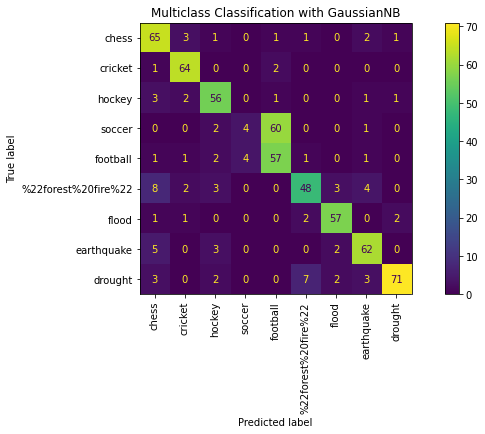

Multiclass Classification with GaussianNB :
Accuracy: 0.7682539682539683
Recall: 0.7682539682539683
Precision: 0.7715769757065303
F1-Score: 0.7435615496183319 



In [ ]:
leaf_labels = ["chess", "cricket", "hockey", "soccer",
"football", "%22forest%20fire%22", "flood", "earthquake",
"drought"]

plot_confusion_matrix(gnb_multi, X_test_LSI_m, y_test_multi, display_labels=leaf_labels)
plt.xticks(rotation=90)
plt.title('Multiclass Classification with GaussianNB')
plt.show()

print_multi_result("Multiclass Classification with GaussianNB", y_test_multi, gnb_multi_y_pred)

In [ ]:
svm_ovo = OneVsOneClassifier(svm.LinearSVC(random_state=42))
svm_ovr = OneVsRestClassifier(svm.LinearSVC(random_state=42))

# fit the model
svm_ovo.fit(X_train_LSI_m, y_train_multi)
svm_ovr.fit(X_train_LSI_m, y_train_multi)

# predict the test data
svm_ovo_pred = svm_ovo.predict(X_test_LSI_m)
svm_ovr_pred = svm_ovr.predict(X_test_LSI_m)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


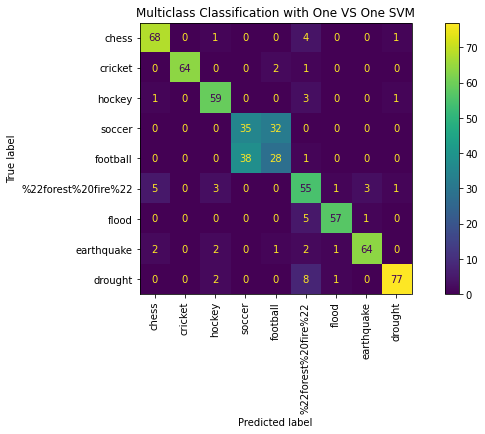

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


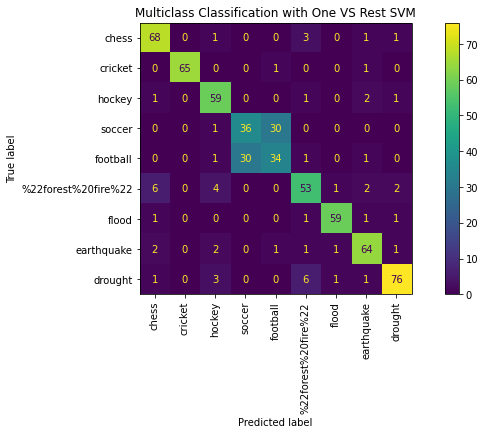

Multiclass Classification with One VS One SVM :
Accuracy: 0.8047619047619048
Recall: 0.8047619047619048
Precision: 0.8113115535782154
F1-Score: 0.8068876370648244 

Multiclass Classification with One VS Rest SVM :
Accuracy: 0.8158730158730159
Recall: 0.8158730158730159
Precision: 0.8161616571017086
F1-Score: 0.8154503193647489 



In [ ]:
plot_confusion_matrix(svm_ovo, X_test_LSI_m, y_test_multi, display_labels=leaf_labels)
plt.xticks(rotation=90)
plt.title('Multiclass Classification with One VS One SVM')
plt.show()

plot_confusion_matrix(svm_ovr, X_test_LSI_m, y_test_multi, display_labels=leaf_labels)
plt.xticks(rotation=90)
plt.title('Multiclass Classification with One VS Rest SVM')
plt.show()

print_multi_result("Multiclass Classification with One VS One SVM", y_test_multi, svm_ovo_pred)
print_multi_result("Multiclass Classification with One VS Rest SVM", y_test_multi, svm_ovr_pred)

### Do you observe any structure in the confusion matrix? Are there distinct visible blocks on the major diagonal? What does this mean?

A:

Yes, there are distinct visible blocks on the major diagonal. In which means that the performance of this model should be not bad, it predict each labels correctly with a good accuracy.

### Based on your observation from the previous part, suggest a subset of labels that should be merged into a new larger label and recompute the accuracy and plot the confusion matrix. How did the accuracy change in One VS One and One VS the rest?

A:

Yes, we get a high error rate on the label **"soccer"** and **"football"** based on the performance. Maybe we can merge these two labels together.

After merging the labels, we can find that the accuracy get increased in both the One VS One and One VS the rest.

There is approximately a **0.1** increase in both the models.

In [ ]:
map_row_to_class = {"chess":0, "cricket":1, "hockey":2, "soccer":3,
"football":3, "%22forest%20fire%22":4, "flood":5, "earthquake":6,
"drought":7}
y_train_multi = train_multi['leaf_label'].map(map_row_to_class)
y_test_multi = test_multi['leaf_label'].map(map_row_to_class)
print(y_train_multi)
gnb_multi = GaussianNB()
gnb_multi.fit(X_train_LSI_m, y_train_multi)
gnb_multi_y_pred = gnb_multi.predict(X_test_LSI_m)

252     2
2488    6
2953    7
2335    5
101     2
       ..
1386    3
5       2
1437    0
110     2
495     1
Name: leaf_label, Length: 2520, dtype: int64


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


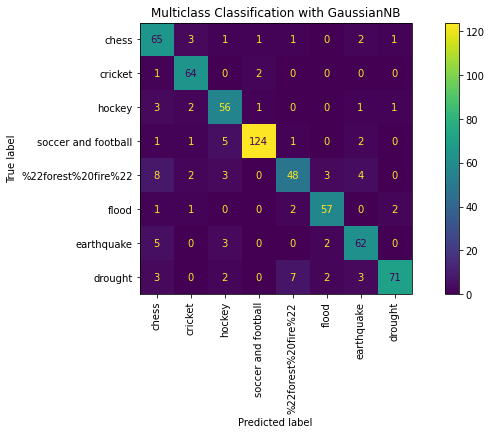

Multiclass Classification with GaussianNB using new labels :
Accuracy: 0.8682539682539683
Recall: 0.8682539682539683
Precision: 0.8731777495849721
F1-Score: 0.8684237224543343 



In [ ]:
leaf_labels = ["chess", "cricket", "hockey", "soccer and football",
"%22forest%20fire%22", "flood", "earthquake",
"drought"]
plot_confusion_matrix(gnb_multi, X_test_LSI_m, y_test_multi, display_labels=leaf_labels)
plt.xticks(rotation=90)
plt.title('Multiclass Classification with GaussianNB')
plt.show()

print_multi_result("Multiclass Classification with GaussianNB using new labels", y_test_multi, gnb_multi_y_pred)

In [ ]:
svm_ovo = OneVsOneClassifier(svm.LinearSVC(random_state=42))
svm_ovr = OneVsRestClassifier(svm.LinearSVC(random_state=42))

# fit the model
svm_ovo.fit(X_train_LSI_m, y_train_multi)
svm_ovr.fit(X_train_LSI_m, y_train_multi)

# predict the test data
svm_ovo_pred = svm_ovo.predict(X_test_LSI_m)
svm_ovr_pred = svm_ovr.predict(X_test_LSI_m)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


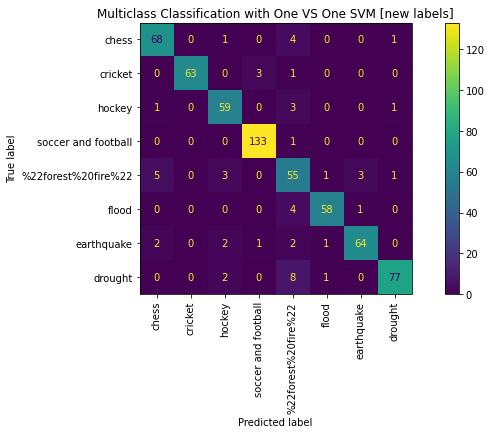

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


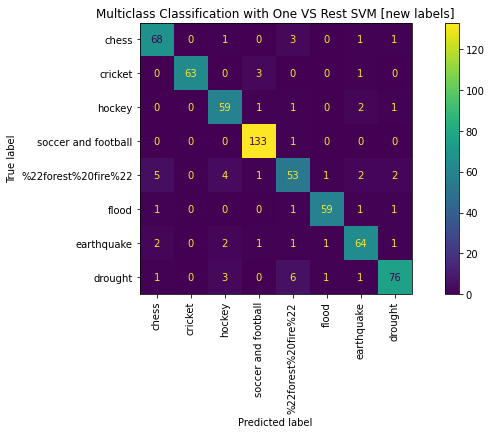

Multiclass Classification with One VS One SVM [new labels] :
Accuracy: 0.9158730158730158
Recall: 0.9158730158730158
Precision: 0.9205895074400356
F1-Score: 0.9172570218871657 

Multiclass Classification with One VS Rest SVM [new labels] :
Accuracy: 0.9126984126984127
Recall: 0.9126984126984127
Precision: 0.9133488309348903
F1-Score: 0.912506227507293 



In [ ]:
plot_confusion_matrix(svm_ovo, X_test_LSI_m, y_test_multi, display_labels=leaf_labels)
plt.xticks(rotation=90)
plt.title('Multiclass Classification with One VS One SVM [new labels]')
plt.show()

plot_confusion_matrix(svm_ovr, X_test_LSI_m, y_test_multi, display_labels=leaf_labels)
plt.xticks(rotation=90)
plt.title('Multiclass Classification with One VS Rest SVM [new labels]')
plt.show()

print_multi_result("Multiclass Classification with One VS One SVM [new labels]", y_test_multi, svm_ovo_pred)
print_multi_result("Multiclass Classification with One VS Rest SVM [new labels]", y_test_multi, svm_ovr_pred)

### Does class imbalance impact the performance of the classification once some classes are merged? Provide a resolution for the class imbalance and recompute the accuracy and plot the confusion matrix in One VS One and One VS the rest?.

A:

We set the parameter **class_weight='balanced'** from the sklearn.svm.LinearSVC. It assigns the weights of each class label so that we can implement the balanced class we want.

As you can see, the accuracy of one vs rest gets increasing after dealing with the imbalance issue. However, the accuracy of one vs one doesn't get improved after dealing with the imbalance issue.

There are many interpretations to explain it. One of the possible explanation might be the model already got a great accuracy which didn’t get influenced by the imbalanced class a lot. Therefore, dealing with the issue doesn't help us get a huge improve of the models. It only helps the one vs rest model get improved a little bit.

In [ ]:
svm_ovo = OneVsOneClassifier(svm.LinearSVC(random_state=42, class_weight='balanced'))
svm_ovr = OneVsRestClassifier(svm.LinearSVC(random_state=42, class_weight='balanced'))

# fit the model
svm_ovo.fit(X_train_LSI_m, y_train_multi)
svm_ovr.fit(X_train_LSI_m, y_train_multi)

# predict the test data
svm_ovo_pred = svm_ovo.predict(X_test_LSI_m)
svm_ovr_pred = svm_ovr.predict(X_test_LSI_m)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


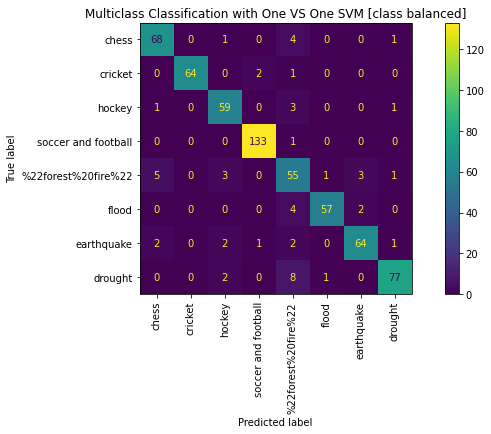

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


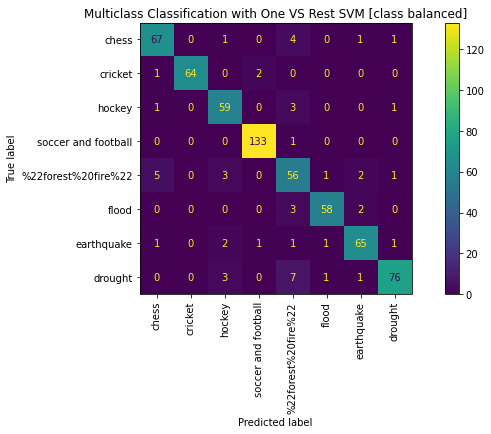

Multiclass Classification with One VS One SVM [class balanced] :
Accuracy: 0.9158730158730158
Recall: 0.9158730158730158
Precision: 0.9204173132218376
F1-Score: 0.9172625910736075 

Multiclass Classification with One VS Rest SVM [class balanced] :
Accuracy: 0.9174603174603174
Recall: 0.9174603174603174
Precision: 0.9204296217678943
F1-Score: 0.9182710137391582 



In [ ]:
plot_confusion_matrix(svm_ovo, X_test_LSI_m, y_test_multi, display_labels=leaf_labels)
plt.xticks(rotation=90)
plt.title('Multiclass Classification with One VS One SVM [class balanced]')
plt.show()

plot_confusion_matrix(svm_ovr, X_test_LSI_m, y_test_multi, display_labels=leaf_labels)
plt.xticks(rotation=90)
plt.title('Multiclass Classification with One VS Rest SVM [class balanced]')
plt.show()

print_multi_result("Multiclass Classification with One VS One SVM [class balanced]", y_test_multi, svm_ovo_pred)
print_multi_result("Multiclass Classification with One VS Rest SVM [class balanced]", y_test_multi, svm_ovr_pred)

# Question 10


### (a) Why are GLoVE embeddings trained on the ratio of co-occurrence probabilities rather than the probabilities themselves?

A:

Relevant relations between words could be extracted using the ratio of co-occurrence, in other words, specific properties and correlations could be extracted from the ratio, while irrelevant words, which may relate to both or neither word in the ratio, could be effectively identified. The use of simple probabilities instead of co-occurrence probabilities loses this property, making it potentially harder to differentiate between relevant and irrelevant words, as shown in the "ice" versus "steam" example in the paper.

### (b) In the two sentences: “James is running in the park.” and “James is running for the presidency.”, would GLoVE embeddings return the same vector for the word running in both cases? Why or why not?

A:

I would expect the GLoVE embeddings of the two to be different for any context window larger than 0, since both syntatic and semantic information greatly depends on the context (i.e. words preceding and following), which is different between the two given cases, as the target word has completely different meanings between them.

### (c) What do you expect for the values of,
||GLoVE["queen"] - GLoVE["king"] - GLoVE["wife"] + GLoVE["husband"]||2,
||GLoVE["queen"] - GLoVE["king"]||2 and ||GLoVE["wife"] - GLoVE["husband"]||2 ?Compare these values.

A:

I would expect ||GLoVE["queen"] - GLoVE["king"] - GLoVE["wife"] + GLoVE["husband"]||2 to be equivalent to the loss of the statement "A king is to a queen as a husband is to a wife", as formulated in section 4.1 of the paper, and since the relation of word analogies hold in this case, I expect the value to be somewhat relatively low.  ||GLoVE["queen"] - GLoVE["king"] ||2 and ||GLoVE["wife"] - GLoVE["husband"]||2, on the other hand, would be equivalent to the difference between "Queen and King" and the difference between "Wife and Husband", respectively, as their GLoVE embedded vectors. I expect both of these distances to be substantially larger than the first case (distance measure with all four terms), while being of similar magnitude, as to cancel out during the first case. In a vector sense, we could also characterize ||GLoVE["queen"] - GLoVE["king"] - GLoVE["wife"] + GLoVE["husband"]||2 as the magnitude of the difference between vectors GLoVE["queen"] - GLoVE["king"] and GLoVE["wife"] - GLoVE["husband"], which we would see the terms with similar magnitude (ones that satisfy the analogy relation) cancel out, leaving us with the sum of the differences between the word pairs.
Interestingly though, as shown in the code snippet below, the actual GLoVE embeddings deviate from this assumption, and the difference between the embeddings for "queen" and "king" are substantially larger than expected, potentially due to additional meanings and usage associated with the respective words, which in turn lead to an increase in the value which pertains to the case with all four words. We believe that this result is akin to the GLoVE embedding telling us that queen to king is actually not a great analogy for wife to husband.

### (d) Given a word, would you rather stem or lemmatize the word before mapping it to its GLoVE embedding?

A:

Assuming that performance is a non-issue (since stemming may be required over lemmatization if this assumption does not hold), I would prefer to lemmatize the words instead of stemming them, as GLoVE works on co-occurrence, specific context or meaning of the words should be preserved, for the model to obtain a better understanding of the underlying relation between words within a vocabulary. Stemming, on the other hand, may destroy this precious information while trading for simplicity and performance, which is likely to be undesirable.

# Question 11


In [ ]:
embeddings_dict = {}
dimension_of_glove = 300
with open("drive/My Drive/ECE 219/glove.6B.300d.txt", 'r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], "float32")
    embeddings_dict[word] = vector

### (a) Describe a feature engineering process that uses GLoVE word embeddings to represent each document.

In [ ]:
#run this code after running definitions in Question 11
qk=embeddings_dict["queen"]-embeddings_dict["king"]
wh=embeddings_dict["wife"]-embeddings_dict["husband"]
def dist(vec):
  sum=0
  for e in vec:
    sum=sum+e**2
  return sum 
print(dist(qk))
print(dist(wh))
print(dist(qk-wh))

35.59623394267456
9.935395484083587
38.00767177356546


In [ ]:
print(list(embeddings_dict.keys())[:100])

['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as', 'it', 'by', 'at', '(', ')', 'from', 'his', "''", '``', 'an', 'be', 'has', 'are', 'have', 'but', 'were', 'not', 'this', 'who', 'they', 'had', 'i', 'which', 'will', 'their', ':', 'or', 'its', 'one', 'after', 'new', 'been', 'also', 'we', 'would', 'two', 'more', "'", 'first', 'about', 'up', 'when', 'year', 'there', 'all', '--', 'out', 'she', 'other', 'people', "n't", 'her', 'percent', 'than', 'over', 'into', 'last', 'some', 'government', 'time', '$', 'you', 'years', 'if', 'no', 'world', 'can', 'three', 'do', ';', 'president', 'only', 'state', 'million', 'could', 'us', 'most', '_', 'against', 'u.s.']


In [ ]:
print(list(embeddings_dict.values())[0])

[ 4.6560e-02  2.1318e-01 -7.4364e-03 -4.5854e-01 -3.5639e-02  2.3643e-01
 -2.8836e-01  2.1521e-01 -1.3486e-01 -1.6413e+00 -2.6091e-01  3.2434e-02
  5.6621e-02 -4.3296e-02 -2.1672e-02  2.2476e-01 -7.5129e-02 -6.7018e-02
 -1.4247e-01  3.8825e-02 -1.8951e-01  2.9977e-01  3.9305e-01  1.7887e-01
 -1.7343e-01 -2.1178e-01  2.3617e-01 -6.3681e-02 -4.2318e-01 -1.1661e-01
  9.3754e-02  1.7296e-01 -3.3073e-01  4.9112e-01 -6.8995e-01 -9.2462e-02
  2.4742e-01 -1.7991e-01  9.7908e-02  8.3118e-02  1.5299e-01 -2.7276e-01
 -3.8934e-02  5.4453e-01  5.3737e-01  2.9105e-01 -7.3514e-03  4.7880e-02
 -4.0760e-01 -2.6759e-02  1.7919e-01  1.0977e-02 -1.0963e-01 -2.6395e-01
  7.3990e-02  2.6236e-01 -1.5080e-01  3.4623e-01  2.5758e-01  1.1971e-01
 -3.7135e-02 -7.1593e-02  4.3898e-01 -4.0764e-02  1.6425e-02 -4.4640e-01
  1.7197e-01  4.6246e-02  5.8639e-02  4.1499e-02  5.3948e-01  5.2495e-01
  1.1361e-01 -4.8315e-02 -3.6385e-01  1.8704e-01  9.2761e-02 -1.1129e-01
 -4.2085e-01  1.3992e-01 -3.9338e-01 -6.7945e-02  1

In [ ]:
print(df['full_text'][0])

Pure Hockey the largest hockey retailer in the US now has over  locations with this being the first in Las Vegas

HOLLISTON MA USA October   EINPresswirecom  Pure Hockey the largest hockey retailer in the US announced today that it has agreed to acquire The Penalty Box a fullservice hockey retailer located in Las Vegas Nevada Through the acquisition Pure Hockey expands its retail presence to Nevada one of the fastestgrowing hockey markets in the United States Pure Hockey now operates over  retail locations across the United States This is Pure Hockeys sixth store opening of  following the expansion in Florida Illinois Pennsylvania and Texas

The acquisition of The Penalty Box provides us with the opportunity to bring our established brand and economies of scale to a hockey market that is experiencing exponential growth said David Nectow CEO Pure Hockey With unmatched customer experience and product selection we look forward to growing with the hockey community in Nevada Were very lucky

In [ ]:
import re
re.findall(r"\w+|[^\w\s]", df['full_text'][0], re.UNICODE)

['Pure',
 'Hockey',
 'the',
 'largest',
 'hockey',
 'retailer',
 'in',
 'the',
 'US',
 'now',
 'has',
 'over',
 'locations',
 'with',
 'this',
 'being',
 'the',
 'first',
 'in',
 'Las',
 'Vegas',
 'HOLLISTON',
 'MA',
 'USA',
 'October',
 'EINPresswirecom',
 'Pure',
 'Hockey',
 'the',
 'largest',
 'hockey',
 'retailer',
 'in',
 'the',
 'US',
 'announced',
 'today',
 'that',
 'it',
 'has',
 'agreed',
 'to',
 'acquire',
 'The',
 'Penalty',
 'Box',
 'a',
 'fullservice',
 'hockey',
 'retailer',
 'located',
 'in',
 'Las',
 'Vegas',
 'Nevada',
 'Through',
 'the',
 'acquisition',
 'Pure',
 'Hockey',
 'expands',
 'its',
 'retail',
 'presence',
 'to',
 'Nevada',
 'one',
 'of',
 'the',
 'fastestgrowing',
 'hockey',
 'markets',
 'in',
 'the',
 'United',
 'States',
 'Pure',
 'Hockey',
 'now',
 'operates',
 'over',
 'retail',
 'locations',
 'across',
 'the',
 'United',
 'States',
 'This',
 'is',
 'Pure',
 'Hockeys',
 'sixth',
 'store',
 'opening',
 'of',
 'following',
 'the',
 'expansion',
 'in',
 '

In [ ]:
def GLoVE(rows,edict):
  embeddings=[]
  sums=[]
  for row in rows:
    words=re.findall(r"\w+|[^\w\s]", row, re.UNICODE)
    embedding=[]
    sum=np.zeros(len(list(edict.values())[0]))
    count=0
    for word in words:
      try:
        sum=sum+edict[word.lower()]
        embedding.append(edict[word.lower()])
        count+=1
      except:
        pass
    embeddings.append(embedding)
    sums.append(sum/count)
  return embeddings,sums

In [ ]:
embeddings,sums=GLoVE(df['full_text'],embeddings_dict)
#print(sums[0])

### (b) Select a classifier model, train and evaluate it with your GLoVE-based feature. If you are doing any cross-validation, please make sure to use a limited set of options so that your code finishes running in a reasonable amount of time.

In [ ]:
#Do classification either on a linear transform of <embeddings> or <sums>
from sklearn.linear_model import LogisticRegression
e300tr,s300tr=GLoVE(train['full_text'],embeddings_dict)
e300te,s300te=GLoVE(test["full_text"],embeddings_dict)
l2c = LogisticRegression(penalty='l2', random_state=9527,C=10, solver='liblinear', max_iter=100000)
l2c.fit(s300tr, y_train)
y_pred = l2c.predict(s300te)
print_result("300d",y_test,y_pred)

300d :
Accuracy: 0.9555555555555556
Recall: 0.9607843137254902
Precision: 0.9607843137254902
F1-Score: 0.9607843137254902 



Here we observe that by aggregating all GLoVE embeddings into a single vector by taking the mean of the embedding vectors for every word in the document, we still retain enough information for our classification model (Logistic regression with l2 regularization) to efficiently differentiate between classes, achieving an accuracy of around 96.19%.

# Question 12


### Plot the relationship between the dimension of the pre-trained GLoVE embedding and the resulting accuracy of the model in the classification task. Describe the observed trend. Is this trend expected? Why or why not? In this part use the different sets of GLoVE vectors from the link.

In [ ]:
embeddings_dict50 = {}
with open("drive/My Drive/ECE 219/glove.6B.50d.txt", 'r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], "float32")
    embeddings_dict50[word] = vector
embeddings_dict100 = {}
with open("drive/My Drive/ECE 219/glove.6B.100d.txt", 'r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], "float32")
    embeddings_dict100[word] = vector
embeddings_dict200 = {}
with open("drive/My Drive/ECE 219/glove.6B.200d.txt", 'r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], "float32")
    embeddings_dict200[word] = vector

In [ ]:
print(len(embeddings_dict50.keys()))
print(len(embeddings_dict100.keys()))
print(len(embeddings_dict200.keys()))
print(len(embeddings_dict.keys()))

print(len(list(embeddings_dict50.values())[0]))
print(len(list(embeddings_dict100.values())[0]))
print(len(list(embeddings_dict200.values())[0]))
print(len(list(embeddings_dict.values())[0]))

400000
400000
400000
400000
50
100
200
300


In [ ]:
#test for different GLoVE embedding lengths
embeddings50,sums50=GLoVE(df['full_text'],embeddings_dict50)
embeddings100,sums100=GLoVE(df['full_text'],embeddings_dict100)
embeddings200,sums200=GLoVE(df['full_text'],embeddings_dict200)
embeddings,sums=GLoVE(df['full_text'],embeddings_dict)
print(sums50[0])
print(sums100[0])
print(sums200[0])
print(sums[0])

[ 0.11808152  0.22990558 -0.12222934  0.20317452  0.22917842  0.01099067
 -0.60533027 -0.14899211  0.03709993 -0.05085494  0.16901407 -0.06579774
 -0.32236872 -0.10306673  0.23485559  0.12555783  0.10734039  0.10842584
 -0.5202819  -0.22861994  0.16113955 -0.04530003 -0.05620816  0.07504799
 -0.22663105 -1.38564248 -0.30931707 -0.01640182  0.08593353 -0.17486748
  2.91103998  0.16496452 -0.09152619 -0.29793145  0.07008224 -0.11174856
 -0.07072981  0.18257383  0.08428842 -0.10541317 -0.09187669  0.01821072
  0.04321849  0.0463882  -0.1829947   0.17775732 -0.21724982 -0.05709987
 -0.08307275 -0.01915587]
[ 4.07397795e-02  5.56342354e-02  3.62399963e-01 -1.62620389e-01
  1.29772164e-01  5.07529724e-03 -6.79727073e-02  1.51621189e-01
 -2.96157855e-01  5.68463067e-02  4.57806767e-02 -2.35985975e-01
  1.73913066e-01 -2.67287683e-02  3.64700638e-03 -2.42156634e-01
  2.97353928e-01  8.78034395e-02 -3.64827260e-01  9.46574348e-02
  2.17246242e-01  1.63256916e-01  1.99675398e-01  9.31260481e-02


In [ ]:
#do classification on all 4 dimension numbers
print_result("300d",y_test,y_pred)
e200tr,s200tr=GLoVE(train['full_text'],embeddings_dict200)
e200te,s200te=GLoVE(test["full_text"],embeddings_dict200)
l2c200 = LogisticRegression(penalty='l2', random_state=9527,C=10, solver='liblinear', max_iter=100000)
l2c200.fit(s200tr, y_train)
y_pred200 = l2c200.predict(s200te)
print_result("200d",y_test,y_pred200)
e100tr,s100tr=GLoVE(train['full_text'],embeddings_dict100)
e100te,s100te=GLoVE(test["full_text"],embeddings_dict100)
l2c100 = LogisticRegression(penalty='l2', random_state=9527,C=10, solver='liblinear', max_iter=100000)
l2c100.fit(s100tr, y_train)
y_pred100 = l2c100.predict(s100te)
print_result("100d",y_test,y_pred100)
e50tr,s50tr=GLoVE(train['full_text'],embeddings_dict50)
e50te,s50te=GLoVE(test["full_text"],embeddings_dict50)
l2c50 = LogisticRegression(penalty='l2', random_state=9527,C=10, solver='liblinear', max_iter=100000)
l2c50.fit(s50tr, y_train)
y_pred50 = l2c50.predict(s50te)
print_result("50d",y_test,y_pred50)

300d :
Accuracy: 0.9555555555555556
Recall: 0.9607843137254902
Precision: 0.9607843137254902
F1-Score: 0.9607843137254902 

200d :
Accuracy: 0.9587301587301588
Recall: 0.9663865546218487
Precision: 0.9610027855153204
F1-Score: 0.9636871508379888 

100d :
Accuracy: 0.9571428571428572
Recall: 0.969187675070028
Precision: 0.9558011049723757
F1-Score: 0.9624478442280946 

50d :
Accuracy: 0.9507936507936507
Recall: 0.957983193277311
Precision: 0.9553072625698324
F1-Score: 0.9566433566433566 



Text(0, 0.5, 'Accuracy')

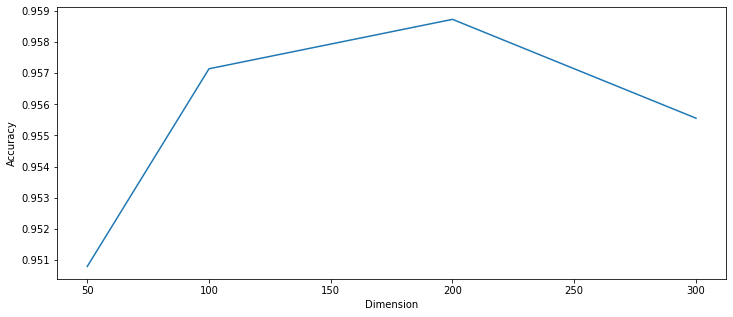

In [ ]:
#plot dimension and accuracy
plt.plot([50,100,200,300],[accuracy_score(y_test,y_pred50),accuracy_score(y_test,y_pred100),accuracy_score(y_test,y_pred200),accuracy_score(y_test,y_pred)])
plt.xlabel("Dimension")
plt.ylabel("Accuracy")

We observe that the accuracy for our classification model is somewhat related to the dimension count of our GLoVE embedding, with the higher dimension embedding we get better accuracy. This is to be expected, as a higher dimension vector is able to preserve more information about the given document, especially after word embeddings are averaged over all words in a document, where individual embeddings may have its information muddled or lost.

# Question 13

### Compare and contrast the two visualizations. Are there clusters formed in either or both of the plots? 

A: 

There are clusters formed in the GLoVE-based Embeddings Vectors but not in the randomized vector. 

In [ ]:
!pip install umap-learn
!pip install umap-learn[plot]
import umap
import umap.plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=e48797c805e23773e2bde58a716e7ddfeec06337a4e369405b1afec403eefe5f
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=763dee45be723811bf3885dbe149ac2f3e62c03df22494aae3f220ba11164ae2
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/pu

Text(0.5, 1.0, 'GLoVE-based Embeddings Vectors')

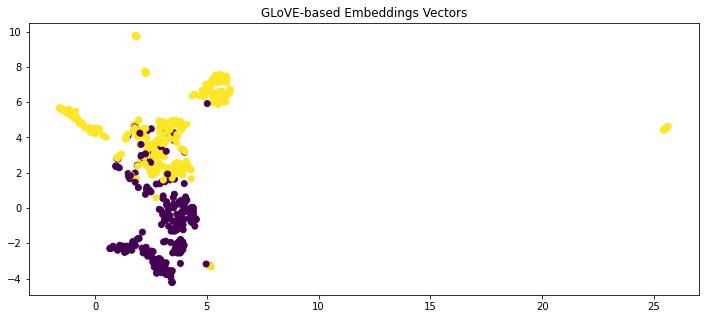

In [ ]:
#Normalized GLoVE-based embeddings of the documents with their binary labels
fit = umap.UMAP()
map = fit.fit_transform(s300te)

scatter = plt.scatter (map[:,0], map[:,1], c = y_test)
plt.title("GLoVE-based Embeddings Vectors")


Text(0.5, 1.0, 'Normalized Random Vectors')

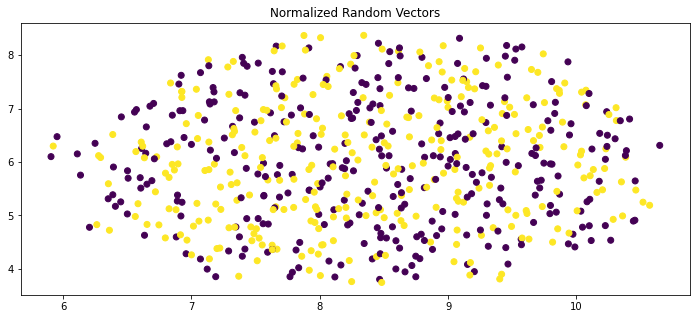

In [ ]:
#Generate a set of normalized random vectors of the same dimension as GLoVE

np.random.seed(9527)
dataset = np.random.rand(len(s300te),len(s300te[0]))
rand = fit.fit_transform(dataset) 
rand_labels = np.random.randint(2, size = rand.shape[0])
plt.scatter(rand[:,0], rand[:,1], c = rand_labels)
plt.title("Normalized Random Vectors")

